# H&M Retail Sales Trending Item Prediction - Advanced Modelling

# Introduction

## Recap
In the previous steps, we've done data preprocessing, EDA, and baseline modelling with H&M sales data. Here are the analysis we've done:

- Data Preprocessing
  - **Articles (product) table**: dealing with coda/name pairs matching for product category related columns, missing values, duplicates.
  - **Customers table**: dealing with missing values (imputation)and check for duplicates.
  - **Transactions table**: dealing with missing values, duplicates, and transform the dataset based on our findings(we identified duplicated rows as purchasing multiple units and created a new column called units that aggregate the duplicates).

- Exploratory Data Analysis
  - **Preliminary EDA**: Analysed and visualized data based on numerical, categorical, and time series features.
  - **Product EDA**: In-depth analysis on different product category related features, visualize data based on hierarchies, and further preprocessing to filter out irrelavant features/data.
  - **Sales EDA (time series)**: Analyzed sales by week case-by-case with products. Selected 1 random product and the top selling product as case study. Visualized growth rate by week.

- Feature Engineering
  - **Target Variable Labelling**: Defined a function that identify "trending" for each product.
  - **Product Table Aggregation**: Aggregate the product table with the created "trending" column as model input.
  - **Input feature engineering**: With the product table, performed vectorization and one-hot encoding to the corresponding features.

- Baseline Modelling
  - Trained a logistic regression model as baseline
  - Implemented imbalanced learning with SMOTE
  - Evaluated the results and looked into feature importance

## Todos

In this part, we will continue our work with advanced modelling. Here are some details:

- **Target Variable (Trending)**: Trending is defined as observing a high volume of sales combined with high week-over-week growth. We use specific thresholds to set precisely what 'high' means.

- **Pipeline**: For efficiency purposes and reusability, here we want to wrap up all our feature engineering steps and modelling with column transformer and pipelines. Tuning the pipeline so that it can run in GPU environments.

- **Modelling**: Train our models with the custom pipeline, do hyperparameter optimization with grid search. (Logistic Regression, SVM, XGBoost, and Random Forest)

- **Word Embeddings**: As mentioned in the previous part, we would like to see if word embeddings would out perform vectorization for our product description input. Here, we will use BERT pretrained model for embedding that. We will modify the input with embedded product description and train the model again to see if the result is different.

- **Interpretable ML**: Use shapely values to understand which features have high impact on predicting trending.

- **Case Studies**: Implement the pipeline on training only for indivudual product type. See if the results change and also view the shapely values.

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings
import joblib
from tqdm import tqdm
import time
import ast
import json

# Sklearn ML
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Text Processing
import string
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Imbalance learning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wellswang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loaing Data and Connect to Drive

Here we load the product data with trending labelled in the previous step.

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
path = '/content/drive/MyDrive/BrainStation/DS/Capstone/'

In [11]:
# Read the data
prod_df = pd.read_csv(path+'data/prod_df.csv')

# Advanced ML Modelling

Using the baseline models and model evaluation strategy you built in the previous part, we will springboard into advanced model building, optimization, evaluation and interpretation. Here are the steps:
- Create a pipeline for tokenization, scaling, and imbalanced learning
- Implement the pipeline for hyperparameter optimization with baseline model
- Apply the methods to other ML models

## Pipeline

For efficiency purposes and reusability, here we want to wrap up all our feature engineering steps and modelling with column transformer and pipelines.

### Defining Functions for pipelines

**Retrive functions for the following steps and create a pipeline function to wrap all the steps together**  
- TfidfVectorizer
- StandardScaler
- OneHotEncoder
- SMOTE Upsamping
- ML model

**First, we need to retrieve our tokenizer**

This is the exact same defined tokenizer function from the prevous notebook.

In [13]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()

    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []

    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words

            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

**Custom Function to add in Pipeline using Function Transformer**

The output of the column transformer is a sparse matrix. Sometimes it will error out when used in pipeline. Hence, we have a custom function here to turn that into an array. This can be put into pipeline by specifying the `FunctionTransformer`.

In [ ]:
# Custom function to convert sparse matrix to dense array
def to_dense(X):
    return X.toarray()

**Defining Pipeline Function**

As mentioned, we are wrapping up everything in this pipeline.

In [ ]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """
    # Columns for one-hot encoding
    categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

    # Create the column transformations list + columns to which to apply
    col_transforms = [('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
                      ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
                      ('normalise', StandardScaler(), ['unit_price']),
                      ('cat', OneHotEncoder(drop='first'), categorical_columns)
                     ]

    # Create the column transformer
    col_trans = ColumnTransformer(col_transforms, remainder='passthrough')

    # List of estimators in the pipeline
    estimators = [('preprocessor', col_trans),
                  ('to_dense', FunctionTransformer(func=to_dense, validate=False)),
                  ('smote', SMOTE(random_state=123)),
                  ('clf', model)
                 ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

### Testing out the pipeline function

**Train Test Split**

In [ ]:
# Spliting features X and target y
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 8) (7241, 8)


**Testing out the pipeline with Logistic Regression Model**

In [ ]:
# Specify the model for the pipeline
model_params = {'random_state':123}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      6475
        True       0.32      0.81      0.46       766

    accuracy                           0.80      7241
   macro avg       0.65      0.80      0.67      7241
weighted avg       0.90      0.80      0.83      7241



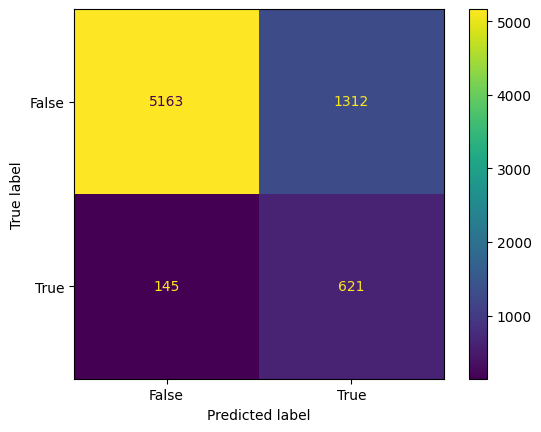

In [ ]:
# Evaluate with confusion matrix
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

Here we can see that we have a slightly higher recall score (**81%**). That might be due to the order difference of our steps (putting standard scaler before one-hot encoder).

### Improve efficiency with GPU and tuning pipeline

Since we want to loop over different hyperparameters and optimize the ML models. We would like to utilize GPU. On the other hand, as vectorizer is taking a lot of time, We would also want to run it separately when doing grid search and hyperparameter optimization. if there are new data coming in the future, we can retrain the model with the previous pipeline function.

**Utilizing GPU from colab with cuml**

With the dependencies import from cuml instead of sklearn, we can utilize the GPU power of Google colab for more efficient training. We might want to restart kernel after installation in order to import successfully.


In [4]:
# install dependencies for cuml
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier

**Run col_trans once for more efficent training**

To Speed up the training process, we separate the column transformer with the pipeline so that we only have to run it once. However, we can always move back to putting them together after we found our optimal model.

In [5]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """

    # List of estimators in the pipeline
    estimators = [
        ('smote', SMOTE(random_state=123)),
        ('clf', model)
        ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [14]:
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [
    ('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
    ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
    ('normalise', StandardScaler(), ['unit_price']),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms, remainder='passthrough')
# col_trans = ColumnTransformer(col_transforms)

In [15]:
# Spliting features X and target y
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train_transformed = col_trans.fit_transform(X_train)
X_test_transformed = col_trans.transform(X_test)

X_train = X_train_transformed.toarray()
X_test = X_test_transformed.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 8) (7241, 8)


((28962, 1128), (7241, 1128))

In [ ]:
X_train_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_train)
X_test_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_test)


# Display the shapes of DataFrames
print("X_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)

X_train_df shape: (28962, 1128)
X_test_df shape: (7241, 1128)


### Model Evaluation

**For model comparison, we also want to create a function that calculates our desired evaluation metrics**

This would help us easily store the evaluation results for different models. We are tracking:
- Model Name (ex. LogReg, XGBoost)
- Model Params (stored in dictionary format)
- Metrics (Precision, Recall, F1 score, Accuracy, False-positive rate)

In [ ]:
def calculate_metrics(model_name, model_params, y_true, y_pred):
    """
    Calculate precision, recall, F1 score, accuracy, and false positive rate.

    Parameters:
    - y_true: true labels
    - y_pred: predicted labels
    - model_name: name of the classification model
    - model_params: dictionary containing the model parameters

    Returns:
    - metrics_df: a dataframe containing precision, recall, f1_score, accuracy, false_positive_rate,
      model_name, and model_params
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate true positives, false positives, false negatives, true negatives
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tn = cm[0, 0]

    # Calculate precision, recall, F1 score, accuracy, and false positive rate
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0.0

    # Create a dictionary to store the metrics and model specifications
    metrics_dict = {
        'model_name': model_name,
        'model_params': model_params,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate
    }

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics_dict])

    # Reorder columns to have model_name and model_params at the front
    columns_order = ['model_name', 'model_params', 'precision', 'recall', 'f1_score', 'accuracy', 'false_positive_rate']
    metrics_df = metrics_df[columns_order]

    # Return the metrics_df
    return metrics_df

**Testing out model evaluation function with baseline model**

We used the created custom function to pass the model results into a dataframe for easy comparison.

In [ ]:
# Extract model specifications
model_name = 'LogisticRegression'
model_params = pipe.named_steps['clf'].get_params()

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

# Display the resulting DataFrame
metrics_df

model_name                                       model_params  \
0  LogisticRegression  {'C': 1.0, 'class_weight': None, 'dual': False...   

   precision    recall  f1_score  accuracy  false_positive_rate  
0   0.321262  0.810705   0.46017  0.798785             0.202625

**Now we have the pipeline and model evaluation function ready, let's try fitting it to logistic regression model.**

## Logistic Regression

### Baseline Logreg

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_params = {}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      6475
        True       0.32      0.81      0.46       766

    accuracy                           0.80      7241
   macro avg       0.65      0.80      0.67      7241
weighted avg       0.90      0.80      0.83      7241



### Hyperparameter Optimization

**Hyperparmater optimization with our baseline model - Using pipeline and custom evaluation function**

Looping through different Cs and store results

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'LogisticRegression'
    model_params = {'C':c}
    model = LogisticRegression(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


model_name  model_params  precision    recall  f1_score  accuracy  \
0  LogisticRegression  {'C': 0.001}   0.257201  0.827676  0.392448  0.728905   
1  LogisticRegression   {'C': 0.01}   0.271296  0.877285  0.414431  0.737743   
2  LogisticRegression    {'C': 0.1}   0.299070  0.839426  0.441015  0.774893   
3  LogisticRegression      {'C': 1}   0.321558  0.808094  0.460052  0.799337   
4  LogisticRegression     {'C': 10}   0.323768  0.780679  0.457711  0.804309   
5  LogisticRegression    {'C': 100}   0.323882  0.775457  0.456923  0.804999   

   false_positive_rate  
0             0.282780  
1             0.278764  
2             0.232741  
3             0.201699  
4             0.192896  
5             0.191506

In [ ]:
# saving logreg results
all_metrics_df.to_csv(path+'data/logreg_results.csv', index=False)

Since the goal for this project is to predict trending items, and the data is imbalanced, what we want to optimize is the recall score instead of accuracy. Hence, we might consider the best logistic regression model to be the one with C=0.01, which can identify 87.7% of trending items.

**Next, we can start applying our pipeline on other models**

## SVM

We would like to run the pipeline on SVM Classifier first. First, we would install dependencies for cuml to allow Google colab to utilize GPU for more efficient training. Next, we look at the baseline SVC model to check if the pipeline and cuml is running correctly. Finally, we would like to use grid search for hyperparameter optimization.

### Baseline SVC

Testing if our pipeline is working fine with SVC using cuml.

In [ ]:
# Specify the model for the pipeline
model_params = {'random_state':123}
model = SVC(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.89      0.92      6475
        True       0.41      0.61      0.49       766

    accuracy                           0.86      7241
   macro avg       0.68      0.75      0.71      7241
weighted avg       0.89      0.86      0.88      7241



### Hyperparameter Optimization

We start with the kernel SVM model here, and loop through different Cs (Regularization Parameter). A smaller C encourages a larger margin and a simpler decision boundary, but may misclassify some points. A larger C gives a lower margin but classifies all training points correctly.

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'SVM'
    model_params = {'C':c, 'kernel':'rbf'}
    model = SVC(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 6/6 [03:20<00:00, 33.37s/it]


model_name                   model_params  precision    recall  f1_score  \
0        SVM  {'C': 0.001, 'kernel': 'rbf'}   0.253412  0.557441  0.348429   
1        SVM   {'C': 0.01, 'kernel': 'rbf'}   0.262642  0.874674  0.403979   
2        SVM    {'C': 0.1, 'kernel': 'rbf'}   0.305825  0.822454  0.445860   
3        SVM      {'C': 1, 'kernel': 'rbf'}   0.407149  0.609661  0.488238   
4        SVM     {'C': 10, 'kernel': 'rbf'}   0.454315  0.467363  0.460746   
5        SVM    {'C': 100, 'kernel': 'rbf'}   0.444921  0.406005  0.424573   

   accuracy  false_positive_rate  
0  0.779450             0.194286  
1  0.726971             0.290502  
2  0.783732             0.220849  
3  0.864798             0.105019  
4  0.884270             0.066409  
5  0.883580             0.059923

In [ ]:
# saving logreg results
all_metrics_df.to_csv(path+'data/svm_results.csv', index=False)

## XGBoost

### Baseline XGBoost

Testing if our pipeline is working fine with XGBoost using cuml.

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.94      0.93      6475
        True       0.44      0.42      0.43       766

    accuracy                           0.88      7241
   macro avg       0.69      0.68      0.68      7241
weighted avg       0.88      0.88      0.88      7241



### Hyperparameter Optimization

Here we use grid search for the hyperparameter optimization of the XGBoost model.

Since XGBoost is not included in cuml, we will have to use the original one and set params to enable training with GPU.

In [ ]:
# Getting GPU id
!nvidia-smi

Fri Jan  5 03:30:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 5 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.71      0.83      6475
        True       0.26      0.86      0.40       766

    accuracy                           0.73      7241
   macro avg       0.62      0.79      0.61      7241
weighted avg       0.90      0.73      0.78      7241



model_name                                       model_params  precision  \
0    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.262928   

     recall  f1_score  accuracy  false_positive_rate  
0  0.862924  0.403049  0.729595             0.286178

In [ ]:
# Extract relevant information from cv_results_
cv_results_df = pd.DataFrame({
    'model_name': ['XGBoost'] * len(grid_search.cv_results_['params']),
    'model_params': grid_search.cv_results_['params'],
    'precision': grid_search.cv_results_['mean_test_precision'],
    'recall': grid_search.cv_results_['mean_test_recall'],
    'f1_score': grid_search.cv_results_['mean_test_f1'],
    'accuracy': grid_search.cv_results_['mean_test_accuracy']
})
cv_results_df

model_name                                       model_params  precision  \
0     XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.259685   
1     XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.264884   
2     XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.294692   
3     XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.335661   
4     XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.371967   
5     XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.315330   
6     XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.372088   
7     XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.417644   
8     XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.443246   
9     XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.469538   
10    XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   0.375086   
11    XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   0.419699   
12    XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   0.460779   
13    XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   0.478075   
14    XGBoost  {'clf__learning_rate': 0.1, 'clf__n_estimators...   0.493370   
15    XGBoost  {'clf__learning_rate': 0.3, 'clf__n_estimators...   0.441440   
16    XGBoost  {'clf__learning_rate': 0.3, 'clf__n_estimators...   0.471186   
17    XGBoost  {'clf__learning_rate': 0.3, 'clf__n_estimators...   0.491154   
18    XGBoost  {'clf__learning_rate': 0.3, 'clf__n_estimators...   0.498348   
19    XGBoost  {'clf__learning_rate': 0.3, 'clf__n_estimators...   0.509149   
20    XGBoost  {'clf__learning_rate': 0.5, 'clf__n_estimators...   0.445220   
21    XGBoost  {'clf__learning_rate': 0.5, 'clf__n_estimators...   0.472425   
22    XGBoost  {'clf__learning_rate': 0.5, 'clf__n_estimators...   0.485416   
23    XGBoost  {'clf__learning_rate': 0.5, 'clf__n_estimators...   0.495013   
24    XGBoost  {'clf__learning_rate': 0.5, 'clf__n_estimators...   0.495842   

      recall  f1_score  accuracy  
0   0.863992  0.399298  0.724743  
1   0.865623  0.405554  0.731234  
2   0.787019  0.428571  0.777674  
3   0.694064  0.452293  0.822112  
4   0.604044  0.460248  0.850148  
5   0.731572  0.440391  0.803121  
6   0.598174  0.458613  0.850563  
7   0.521200  0.463469  0.872315  
8   0.479452  0.460464  0.881120  
9   0.443249  0.455911  0.888060  
10  0.597521  0.460524  0.851909  
11  0.517939  0.463030  0.873006  
12  0.450750  0.455580  0.885989  
13  0.425310  0.450079  0.889994  
14  0.394977  0.438600  0.892998  
15  0.464123  0.452341  0.881051  
16  0.417156  0.442412  0.888716  
17  0.390411  0.434972  0.892652  
18  0.378343  0.430014  0.893861  
19  0.365949  0.425664  0.895484  
20  0.422374  0.433455  0.883157  
21  0.391389  0.427885  0.889303  
22  0.368558  0.418920  0.891789  
23  0.367580  0.421746  0.893378  
24  0.362035  0.418403  0.893481

In [ ]:
# saving XGBoost results all models
cv_results_df.to_csv(path+'data/XGBoost_results_all.csv', index=False)

In [ ]:
# saving XGBoost results best model (X_test)
metrics_df.to_csv(path+'data/XGBoost_results.csv', index=False)

## Random Forest

### Baseline RF

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.92      0.93      6475
        True       0.39      0.41      0.40       766

    accuracy                           0.87      7241
   macro avg       0.66      0.67      0.66      7241
weighted avg       0.87      0.87      0.87      7241



### Hyperparameter Optimization

Here we use grid search for the hyperparameter optimization of the XGBoost model

**Grid Search**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'RandomForest'
model_params = {}
model = RandomForestClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10, 15],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [3, 5]
}

# Record the start time
start_time = time.time()

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Elapsed Time: 1 minutes
Best hyperparameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.79      0.86      6475
        True       0.25      0.59      0.36       766

    accuracy                           0.77      7241
   macro avg       0.60      0.69      0.61      7241
weighted avg       0.87      0.77      0.81      7241



model_name                                       model_params  precision  \
0  RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...    0.25477   

     recall  f1_score  accuracy  false_positive_rate  
0  0.592689  0.356358  0.773512             0.205097

We would like to know how the other model performs on the metrics except for the model with best recall. We can do that by getting them from `grid_search.cv_results_`

In [ ]:
# Extract relevant information from cv_results_
cv_results_df = pd.DataFrame({
    'model_name': ['RandomForest'] * len(grid_search.cv_results_['params']),
    'model_params': grid_search.cv_results_['params'],
    'precision': grid_search.cv_results_['mean_test_precision'],
    'recall': grid_search.cv_results_['mean_test_recall'],
    'f1_score': grid_search.cv_results_['mean_test_f1'],
    'accuracy': grid_search.cv_results_['mean_test_accuracy']
})
cv_results_df

model_name                                       model_params  \
0   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
1   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
2   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
3   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
4   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
5   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
6   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
7   RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
8   RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
9   RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
10  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
11  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
12  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
13  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
14  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
15  RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
16  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
17  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
18  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
19  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
20  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
21  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
22  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   
23  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   

    precision    recall  f1_score  accuracy  
0    0.254562  0.589041  0.355118  0.773773  
1    0.252748  0.564905  0.348913  0.776811  
2    0.254923  0.591650  0.355969  0.773565  
3    0.252454  0.565884  0.348820  0.776328  
4    0.254547  0.590346  0.355359  0.773496  
5    0.252831  0.568167  0.349649  0.776293  
6    0.254547  0.590346  0.355359  0.773496  
7    0.252831  0.568167  0.349649  0.776293  
8    0.324531  0.532616  0.403024  0.833126  
9    0.326924  0.509785  0.398067  0.836855  
10   0.322707  0.529354  0.400539  0.832505  
11   0.331605  0.519569  0.404422  0.838167  
12   0.322827  0.542401  0.404231  0.831054  
13   0.326863  0.533594  0.404896  0.834162  
14   0.322827  0.542401  0.404231  0.831054  
15   0.326863  0.533594  0.404896  0.834162  
16   0.389593  0.460535  0.421731  0.866480  
17   0.393782  0.440639  0.415532  0.868932  
18   0.382132  0.446184  0.411293  0.864892  
19   0.387365  0.431181  0.407846  0.867585  
20   0.380090  0.465101  0.417820  0.863062  
21   0.385481  0.451729  0.415689  0.865755  
22   0.380090  0.465101  0.417820  0.863062  
23   0.385481  0.451729  0.415689  0.865755

Random Forest clearly is not performing better than the other models in terms of precision and recall. Perhaps we can conduct some dimensionality reduction in the future to fit better. For now, we would want to stop here and move on.

In [ ]:
# saving RF results (best_model)
metrics_df.to_csv(path+'data/RF_results.csv', index=False)

In [ ]:
# saving RD results (all models)
cv_results_df.to_csv(path+'data/RF_results_all.csv', index=False)

## Model Comparison

Now we have save the metrics for all models, we can combine them and compare their performance.

In [ ]:
metrics_df_lr = pd.read_csv(path+'data/logreg_results.csv')
metrics_df_svm = pd.read_csv(path+'data/svm_results.csv')
metrics_df_xgboost = pd.read_csv(path+'data/XGBoost_results.csv')
metrics_df_rf = pd.read_csv(path+'data/RF_results.csv')
model_comp = pd.concat([metrics_df_lr, metrics_df_svm, metrics_df_xgboost, metrics_df_rf], ignore_index=True)
model_comp

model_name                                       model_params  \
0   LogisticRegression                                       {'C': 0.001}   
1   LogisticRegression                                        {'C': 0.01}   
2   LogisticRegression                                         {'C': 0.1}   
3   LogisticRegression                                           {'C': 1}   
4   LogisticRegression                                          {'C': 10}   
5   LogisticRegression                                         {'C': 100}   
6                  SVM                      {'C': 0.001, 'kernel': 'rbf'}   
7                  SVM                       {'C': 0.01, 'kernel': 'rbf'}   
8                  SVM                        {'C': 0.1, 'kernel': 'rbf'}   
9                  SVM                          {'C': 1, 'kernel': 'rbf'}   
10                 SVM                         {'C': 10, 'kernel': 'rbf'}   
11                 SVM                        {'C': 100, 'kernel': 'rbf'}   
12             XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
13        RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   

    precision    recall  f1_score  accuracy  false_positive_rate  
0    0.257201  0.827676  0.392448  0.728905             0.282780  
1    0.271296  0.877285  0.414431  0.737743             0.278764  
2    0.299070  0.839426  0.441015  0.774893             0.232741  
3    0.321558  0.808094  0.460052  0.799337             0.201699  
4    0.323768  0.780679  0.457711  0.804309             0.192896  
5    0.323882  0.775457  0.456923  0.804999             0.191506  
6    0.253412  0.557441  0.348429  0.779450             0.194286  
7    0.262642  0.874674  0.403979  0.726971             0.290502  
8    0.305825  0.822454  0.445860  0.783732             0.220849  
9    0.407149  0.609661  0.488238  0.864798             0.105019  
10   0.454315  0.467363  0.460746  0.884270             0.066409  
11   0.444921  0.406005  0.424573  0.883580             0.059923  
12   0.262928  0.862924  0.403049  0.729595             0.286178  
13   0.254770  0.592689  0.356358  0.773512             0.205097

If we look at recall score only then we can get the best model params for each model as below. The model with highest recall is LogisticRegression (87.7%) with almost the same performance compared with SVM (87.4%). However, if we look at f1 score, then the best performing model would be SVM with a trade off on recall (60.9%) but with way higher precision (40.7%). We can also see that the false positive rate have dropped to 10% for the SVM model with the highest f1 score.

In [ ]:
best_models = model_comp.loc[model_comp.groupby('model_name')['recall'].idxmax()]
best_models = best_models.sort_values('recall', ascending=False).reset_index(drop=True)
best_models

model_name                                       model_params  \
0  LogisticRegression                                        {'C': 0.01}   
1                 SVM                       {'C': 0.01, 'kernel': 'rbf'}   
2             XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
3        RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   

   precision    recall  f1_score  accuracy  false_positive_rate  
0   0.271296  0.877285  0.414431  0.737743             0.278764  
1   0.262642  0.874674  0.403979  0.726971             0.290502  
2   0.262928  0.862924  0.403049  0.729595             0.286178  
3   0.254770  0.592689  0.356358  0.773512             0.205097

For the model with best f1 scores, for XGBoost and RandomForest, we will have to look at the params saved from grid search, pick the best ones, and retrain them.

In [ ]:
# Read saved the cv_results from grid search
all_metrics_df_xgboost = pd.read_csv(path+'data/XGBoost_results_all.csv')
all_metrics_df_rf = pd.read_csv(path+'data/RF_results_all.csv')
all_metrics_df = pd.concat([all_metrics_df_xgboost, all_metrics_df_rf], ignore_index=True)

# get the model name and params for best f1 score
best_f1 = all_metrics_df.loc[all_metrics_df.groupby('model_name')['f1_score'].idxmax()].reset_index(drop=True)
best_f1.head()

model_name                                       model_params  precision  \
0  RandomForest  {'clf__max_depth': 15, 'clf__min_samples_leaf'...   0.389593   
1       XGBoost  {'clf__learning_rate': 0.05, 'clf__n_estimator...   0.417644   

     recall  f1_score  accuracy  
0  0.460535  0.421731  0.866480  
1  0.521200  0.463469  0.872315

With the model_name and model_params, we can get the testing results by training it again.

In [ ]:
# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# Specify the model for the pipeline
model_name = ['RandomForest', 'XGBoost']
model_params = [ast.literal_eval(a) for a in best_f1['model_params'].tolist()]
# Remove 'clf__' prefix from all keys
model_params = [{key.replace('clf__', ''): value for key, value in params.items()} for params in model_params]
model = [RandomForestClassifier(**model_params[0]), XGBClassifier(**model_params[1])]

# Looping through two models
for model_name, model_params, model in zip(model_name, model_params, model):
  # Instantiate pipeline with our custom function
  pipe = hm_pipeline(model)

  # Fitting the pipeline with training data
  pipe.fit(X_train, y_train)

  # Predicting with test data
  y_pred = pipe.predict(X_test)

  # Calculate metrics and include model specifications
  metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

  # Append the metrics_df to the all_metrics_df
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

model_name                                       model_params  precision  \
0  RandomForest  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...   0.374637   
1       XGBoost       {'learning_rate': 0.05, 'n_estimators': 200}   0.406061   

     recall  f1_score  accuracy  false_positive_rate  
0  0.505222  0.430239  0.858445             0.099768  
1  0.524804  0.457859  0.868526             0.090811

Let's get them back to our model_comp dataframe as model_comp2. Next, we can retrieve all models with best f1 score.

In [ ]:
model_comp2 = pd.concat([all_metrics_df, model_comp], ignore_index=True)
best_models_f1 = model_comp2.loc[model_comp2.groupby('model_name')['f1_score'].idxmax()]
best_models_f1 = best_models_f1.sort_values('f1_score', ascending=False).reset_index(drop=True)
best_models_f1

model_name                                       model_params  \
0                 SVM                          {'C': 1, 'kernel': 'rbf'}   
1  LogisticRegression                                           {'C': 1}   
2             XGBoost       {'learning_rate': 0.05, 'n_estimators': 200}   
3        RandomForest  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...   

   precision    recall  f1_score  accuracy  false_positive_rate  
0   0.407149  0.609661  0.488238  0.864798             0.105019  
1   0.321558  0.808094  0.460052  0.799337             0.201699  
2   0.406061  0.524804  0.457859  0.868526             0.090811  
3   0.374637  0.505222  0.430239  0.858445             0.099768

Finally we can combine the models as best candidates.

In [ ]:
best_models['best'] = 'recall'
best_models_f1['best'] = 'f1_score'
candidates = pd.concat([best_models, best_models_f1], ignore_index=True)
candidates

model_name                                       model_params  \
0  LogisticRegression                                        {'C': 0.01}   
1                 SVM                       {'C': 0.01, 'kernel': 'rbf'}   
2             XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
3        RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
4                 SVM                          {'C': 1, 'kernel': 'rbf'}   
5  LogisticRegression                                           {'C': 1}   
6             XGBoost       {'learning_rate': 0.05, 'n_estimators': 200}   
7        RandomForest  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...   

   precision    recall  f1_score  accuracy  false_positive_rate      best  
0   0.271296  0.877285  0.414431  0.737743             0.278764    recall  
1   0.262642  0.874674  0.403979  0.726971             0.290502    recall  
2   0.262928  0.862924  0.403049  0.729595             0.286178    recall  
3   0.254770  0.592689  0.356358  0.773512             0.205097    recall  
4   0.407149  0.609661  0.488238  0.864798             0.105019  f1_score  
5   0.321558  0.808094  0.460052  0.799337             0.201699  f1_score  
6   0.406061  0.524804  0.457859  0.868526             0.090811  f1_score  
7   0.374637  0.505222  0.430239  0.858445             0.099768  f1_score

In [ ]:
# Save candidates
# candidates.to_csv(path+'data/candidates.csv', index=False)

We can also visualize the results:

In [18]:
candidates = pd.read_csv(path+'data/candidates.csv')
candidates['best'] = candidates['model_name']+'-'+candidates['best']
candidates

model_name                                       model_params  \
0  LogisticRegression                                        {'C': 0.01}   
1                 SVM                       {'C': 0.01, 'kernel': 'rbf'}   
2             XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
3        RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
4                 SVM                          {'C': 1, 'kernel': 'rbf'}   
5  LogisticRegression                                           {'C': 1}   
6             XGBoost       {'learning_rate': 0.05, 'n_estimators': 200}   
7        RandomForest  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...   

   precision    recall  f1_score  accuracy  false_positive_rate  \
0   0.271296  0.877285  0.414431  0.737743             0.278764   
1   0.262642  0.874674  0.403979  0.726971             0.290502   
2   0.262928  0.862924  0.403049  0.729595             0.286178   
3   0.254770  0.592689  0.356358  0.773512             0.205097   
4   0.407149  0.609661  0.488238  0.864798             0.105019   
5   0.321558  0.808094  0.460052  0.799337             0.201699   
6   0.406061  0.524804  0.457859  0.868526             0.090811   
7   0.374637  0.505222  0.430239  0.858445             0.099768   

                          best  
0    LogisticRegression-recall  
1                   SVM-recall  
2               XGBoost-recall  
3          RandomForest-recall  
4                 SVM-f1_score  
5  LogisticRegression-f1_score  
6             XGBoost-f1_score  
7        RandomForest-f1_score

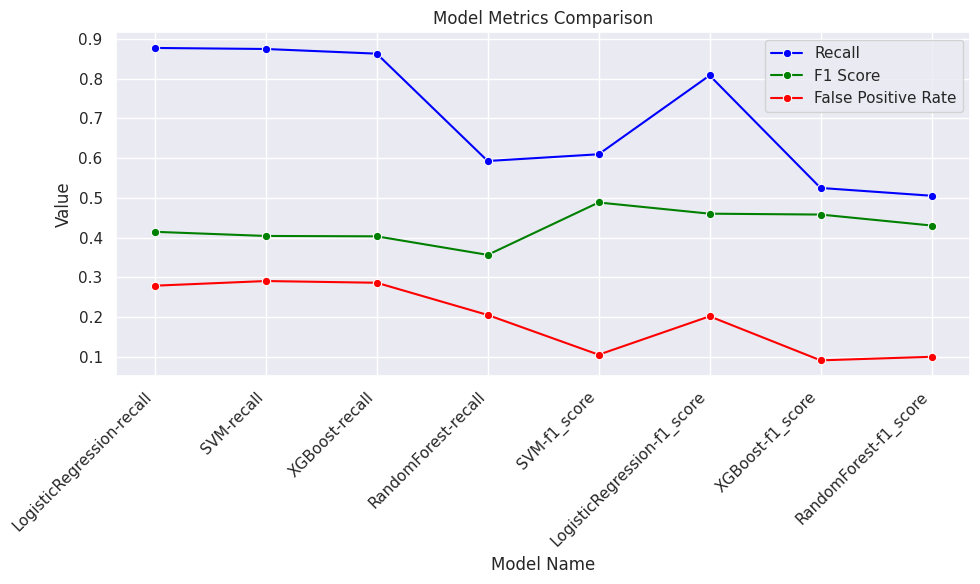

In [19]:
df = candidates.copy()

# Set seaborn style
sns.set(style="darkgrid")

# Plotting
plt.figure(figsize=(10, 6))

# Recall
sns.lineplot(x='best', y='recall', data=df, marker='o', label='Recall', color='blue')

# F1 Score
sns.lineplot(x='best', y='f1_score', data=df, marker='o', label='F1 Score', color='green')

# False Positive Rate
sns.lineplot(x='best', y='false_positive_rate', data=df, marker='o', label='False Positive Rate', color='red')

# Labels and title
plt.xlabel('Model Name')
plt.ylabel('Value')
plt.title('Model Metrics Comparison')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('Model Comparison.png')
plt.show()

We can see that the best models optimized for recall is really similar between logistic regression, SVM, and XGBoost. Random Forest performs not as good but we've tried using PCA in the pipeline and it got a similar results with the other 3. In terms of f1 score, we are seeing SVM out performs the other models. Hence, depends on the use case, we might select different models:

- If we just want to get the most trending item to be identified, and we have personel to safe guard those that are not really trending (high false positive rate don't hurt that much), then we might opt for model that optimized recall.

- If we just want to identify new opportunities, at the same time don't want to spent too much time going through the items. We can opt for the model that has lower false positive rate but with a trade-off of lower recall.


# Modify Model Inputs and train again

Previously, we used TF-IDF vectorizer for our product description column (`detail_desc`) and product name column (`prod_name`). Here, we apply the word embeddings method instead. We want to see if this would improve the model performance.

## Word Embeddings with BERT for product descriptions
BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that captures contextualized word representations. Let's implement it on our product description and name, and see if it performs better than the TF-IDF vectorizer.

In [ ]:
prod_df['detail_desc']

0        Lace push-up bras with underwired, moulded, pa...
1        Lace push-up body with underwired, moulded, pa...
2        Jumper in rib-knit cotton with hard-worn detai...
3        V-neck knitted jumper with long sleeves and ri...
4        Trousers in woven fabric with a high, paper ba...
                               ...                        
36198    Set with a long-sleeved top in sweatshirt fabr...
36199    Whooli Chen x H&M. Joggers in sweatshirt fabri...
36200    Calf-length dress in a jacquard weave with a r...
36201    Hoodie in soft sweatshirt fabric with a text p...
36202    Long-sleeved jacket in soft faux shearling wit...
Name: detail_desc, Length: 36203, dtype: object

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn

# Check if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(BertModel.from_pretrained("bert-base-uncased")).to(device)
else:
    model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load dataset
prod_df = pd.read_csv(path+'data/prod_df.csv')
df = prod_df.copy()

# Tokenize and obtain BERT embeddings for the 'detail_desc' column
def get_bert_embeddings(text):
    tokens = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Apply BERT embeddings to the 'detail_desc' column with a progress bar
tqdm.pandas()
df['desc_embeddings'] = df['detail_desc'].progress_apply(get_bert_embeddings)

# Display the results
df.head()


100%|██████████| 36203/36203 [06:13<00:00, 96.86it/s]


product_id                 prod_name  \
0      541518   Rae Push (Melbourne) 2p   
1      663713  Atlanta Push Body Harlow   
2      505221               Inca Jumper   
3      685687      W YODA KNIT OL OFFER   
4      501323      Thomas paperbag wide   

                                         detail_desc product_type_name  \
0  Lace push-up bras with underwired, moulded, pa...               Bra   
1  Lace push-up body with underwired, moulded, pa...    Underwear body   
2  Jumper in rib-knit cotton with hard-worn detai...           Sweater   
3  V-neck knitted jumper with long sleeves and ri...           Sweater   
4  Trousers in woven fabric with a high, paper ba...          Trousers   

   product_group_name index_group_name                section_name  \
0           Underwear       Ladieswear             Womens Lingerie   
1           Underwear       Ladieswear             Womens Lingerie   
2  Garment Upper body          Divided            Divided Selected   
3  Garment Upper body       Ladieswear  Womens Everyday Collection   
4  Garment Lower body       Ladieswear            Womens Tailoring   

  graphical_appearance_name  unit_price  trending  \
0                     Solid    0.030492      True   
1                     Solid    0.050831     False   
2                   Melange    0.020322     False   
3                   Melange    0.016932      True   
4                     Check    0.059305      True   

                                     desc_embeddings  
0  [[-0.03074159, -0.6750552, -0.036551304, 0.268...  
1  [[-0.1293021, -0.49551082, 0.11073986, 0.26972...  
2  [[-0.24030702, -0.75535846, -0.08416743, 0.011...  
3  [[0.20981042, -0.637014, 0.04346023, -0.182535...  
4  [[-0.017200207, -0.53088826, -0.07241016, 0.07...

In [ ]:
# Apply BERT embeddings to the 'detail_desc' column with a progress bar
tqdm.pandas()
df['name_embeddings'] = df['prod_name'].progress_apply(get_bert_embeddings)

# Display the results
df.head()

100%|██████████| 36203/36203 [05:44<00:00, 105.04it/s]


product_id                 prod_name  \
0      541518   Rae Push (Melbourne) 2p   
1      663713  Atlanta Push Body Harlow   
2      505221               Inca Jumper   
3      685687      W YODA KNIT OL OFFER   
4      501323      Thomas paperbag wide   

                                         detail_desc product_type_name  \
0  Lace push-up bras with underwired, moulded, pa...               Bra   
1  Lace push-up body with underwired, moulded, pa...    Underwear body   
2  Jumper in rib-knit cotton with hard-worn detai...           Sweater   
3  V-neck knitted jumper with long sleeves and ri...           Sweater   
4  Trousers in woven fabric with a high, paper ba...          Trousers   

   product_group_name index_group_name                section_name  \
0           Underwear       Ladieswear             Womens Lingerie   
1           Underwear       Ladieswear             Womens Lingerie   
2  Garment Upper body          Divided            Divided Selected   
3  Garment Upper body       Ladieswear  Womens Everyday Collection   
4  Garment Lower body       Ladieswear            Womens Tailoring   

  graphical_appearance_name  unit_price  trending  \
0                     Solid    0.030492      True   
1                     Solid    0.050831     False   
2                   Melange    0.020322     False   
3                   Melange    0.016932      True   
4                     Check    0.059305      True   

                                     desc_embeddings  \
0  [[-0.03074159, -0.6750552, -0.036551304, 0.268...   
1  [[-0.1293021, -0.49551082, 0.11073986, 0.26972...   
2  [[-0.24030702, -0.75535846, -0.08416743, 0.011...   
3  [[0.20981042, -0.637014, 0.04346023, -0.182535...   
4  [[-0.017200207, -0.53088826, -0.07241016, 0.07...   

                                     name_embeddings  
0  [[-0.012290875, -0.22316156, 0.002212319, -0.1...  
1  [[0.1501672, -0.25465113, 0.07398268, -0.02863...  
2  [[0.17801243, 0.06579128, -0.4711785, 0.192180...  
3  [[0.07526768, -0.09363858, -0.02922254, -0.231...  
4  [[0.014171898, 0.12224587, -0.45284054, 0.0926...

In [ ]:
# Function to split arrays into separate columns
def split_array_desc(row):
    return pd.Series(row['desc_embeddings'][0])
def split_array_name(row):
    return pd.Series(row['name_embeddings'][0])

# Apply the function to create new columns for desc
num_columns = df['desc_embeddings'][0].shape[1]
desc_columns = [f'desc_emb{i+1}' for i in range(num_columns)]
df[desc_columns] = df.apply(split_array_desc, axis=1)

# Apply the function to create new columns for name
num_columns = df['name_embeddings'][0].shape[1]
name_columns = [f'name_emb{i+1}' for i in range(num_columns)]
df[name_columns] = df.apply(split_array_name, axis=1)

In [ ]:
# Dropping after conversion
df.drop(['detail_desc', 'prod_name', 'desc_embeddings', 'name_embeddings'], axis=1, inplace=True)
df.shape

(36203, 1544)

In [ ]:
# Save embedded df
df.to_csv(path+'data/prod_df_embedded.csv', index=False)

In [ ]:
# df = pd.read_csv(path+'data/prod_df_embedded.csv')

In [ ]:
# Spliting features X and target y
X = df.drop(['trending', 'product_id'], axis=1)
y = df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

(28962, 1542) (7241, 1542)


## Reconstructing Column Transformer
Here we reconstruct our pipeline to remove the vectorizer in column transformer since we are using word embeddings. The pipeline will remain the same for now since we are separating it with col_trans.

To Speed up the grid search process, we separate the column transformer with the pipeline so that we only have to run it once. However, we can always move back to putting them together after we found our optimal model.

In [ ]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """

    # List of estimators in the pipeline
    estimators = [
        ('smote', SMOTE(random_state=123)),
        # ('pca', PCA(n_components=0.8)),
        ('clf', model)
        ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [ ]:
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [
    ('normalise', StandardScaler(), ['unit_price']),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
]

# Create the column transformer
col_trans = ColumnTransformer(col_transforms, remainder='passthrough')

In [ ]:
# Spliting features X and target y
X = df.drop(['trending', 'product_id'], axis=1)
y = df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

# X_train = X_train.toarray()
# X_test = X_test.toarray()
# y_train = np.array(y_train)
# y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 1542) (7241, 1542)


((28962, 1664), (7241, 1664))

## Training with previous best parameters
We use the best params from our models trained previously. As a baseline to our BERT version model. Let's create a function for that.

In [ ]:
# Load candidates dataframe
candidates = pd.read_csv(path+'data/candidates.csv')

In [ ]:
def get_params(model, metric):
    """
    Retrieve the best hyperparameters for a specific machine learning model based on a given evaluation metric.

    Parameters:
    - model (str): The name of the machine learning model (e.g., 'LogisticRegression').
    - metric (str): The evaluation metric used to select the best hyperparameters (e.g., 'recall').

    Returns:
    dict: A dictionary containing the best hyperparameters for the specified model and metric.

    Example:
    >>> get_params('LogisticRegression', 'recall')
    {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
    """

    # Conditions to filter candidates DataFrame
    conditions = (candidates['model_name'] == model) & (candidates['best'] == metric)

    # Extract the model_params string for the specified model and metric
    p = candidates.loc[conditions, 'model_params'].values[0]
    display(candidates[conditions])

    # Convert the model_params string to a dictionary using ast.literal_eval
    return ast.literal_eval(p)

## Logistic Regression - BERT

### Basline LR-BERT

In [ ]:
# Get params for logreg
get_params('LogisticRegression', 'recall')

model_name model_params  precision    recall  f1_score  accuracy  \
0  LogisticRegression  {'C': 0.01}   0.271296  0.877285  0.414431  0.737743   

   false_positive_rate    best  
0             0.278764  recall

{'C': 0.01}

In [ ]:
np.random.seed(123)

# Specify the model for the pipeline
model_params = {'C': 0.01}
model = LogisticRegression(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Fitting the pipeline with training data
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.78      0.87      6475
        True       0.30      0.78      0.43       766

    accuracy                           0.78      7241
   macro avg       0.63      0.78      0.65      7241
weighted avg       0.90      0.78      0.82      7241



We can see that it is not performing better than our TF-IDF one.

### Hyperparameter Optimization LR-BERT

**Fitting with liblinear solver (L2 Regularization)**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'LR-BERT'
    model_params = {'C':c, 'solver':'liblinear'}
    model = LogisticRegression(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 3/3 [01:39<00:00, 33.22s/it]


model_name                         model_params  precision    recall  \
0    LR-BERT  {'C': 0.001, 'solver': 'liblinear'}   0.269439  0.778068   
1    LR-BERT   {'C': 0.01, 'solver': 'liblinear'}   0.297392  0.774151   
2    LR-BERT    {'C': 0.1, 'solver': 'liblinear'}   0.309392  0.731070   

   f1_score  accuracy  false_positive_rate  
0  0.400269  0.753349             0.249575  
1  0.429710  0.782627             0.216371  
2  0.434783  0.798923             0.193050

The results seems worse than our previous best. We can try again with l1 penalty.

**Fitting with L1 Regularization (Saga Solver)**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'LR-BERT'
    model_params = {'C':c, 'penalty':'l1', 'solver':'saga'}
    model = LogisticRegression(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 3/3 [04:53<00:00, 97.92s/it] 


model_name                                     model_params  precision  \
0    LR-BERT  {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}   0.181252   
1    LR-BERT   {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}   0.257231   
2    LR-BERT    {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}   0.305316   

     recall  f1_score  accuracy  false_positive_rate  
0  0.835509  0.297882  0.583345             0.446486  
1  0.870757  0.397142  0.720342             0.297452  
2  0.787206  0.439985  0.788013             0.211892

The results seems to be better, still slightly worse than our previous best model.

**Fitting with liblinear solver with L1 regularization**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'LR-BERT'
    model_params = {'C':c, 'penalty':'l1', 'solver':'liblinear'}
    model = LogisticRegression(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 4/4 [27:30<00:00, 412.60s/it]


model_name                                       model_params  precision  \
0    LR-BERT  {'C': 0.001, 'penalty': 'l1', 'solver': 'libli...   0.181325   
1    LR-BERT  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...   0.258340   
2    LR-BERT  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...   0.305008   
3    LR-BERT   {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}   0.315758   

     recall  f1_score  accuracy  false_positive_rate  
0  0.828982  0.297563  0.585969             0.442780  
1  0.869452  0.398325  0.722138             0.295290  
2  0.787206  0.439665  0.787737             0.212201  
3  0.695822  0.434393  0.808314             0.178378

The recall and f1 score is pretty close to L1 with Saga solver.

In general, we can see that LR-BERT is performing slightly worse than the one with Vectorizer in terms of both recall and f1 score.

In [ ]:
# saving logreg results
all_metrics_df.to_csv(path+'data/LR-BERT_results.csv', index=False)

## XGBoost - BERT

### Baseline XGBoost-BERT

In [ ]:
# Getting previous best model
get_params('XGBoost', 'recall')

model_name                                       model_params  precision  \
2    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.262928   

     recall  f1_score  accuracy  false_positive_rate    best  
2  0.862924  0.403049  0.729595             0.286178  recall

{'clf__learning_rate': 0.01, 'clf__n_estimators': 100}

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'clf__learning_rate': 0.01,
                'clf__n_estimators': 100,
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.94      0.93      6475
        True       0.41      0.34      0.37       766

    accuracy                           0.88      7241
   macro avg       0.67      0.64      0.65      7241
weighted avg       0.87      0.88      0.87      7241



Apparently the best params for TF-IDF input doesn't quite fit to our word embeddings model. Let's try running a grid search.

### Hyperparameter Optimization XGBoost-BERT

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'XGBoost-BERT'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 13 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.72      0.83      6475
        True       0.26      0.86      0.40       766

    accuracy                           0.73      7241
   macro avg       0.62      0.79      0.62      7241
weighted avg       0.90      0.73      0.78      7241



model_name                                       model_params  precision  \
0  XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...    0.26434   

     recall  f1_score  accuracy  false_positive_rate  
0  0.860313  0.404419  0.731943             0.283243

We can see the results with BERT and TF-IDF are almost the same in terms of recall.

In [ ]:
# Extract relevant information from cv_results_
cv_results_df = pd.DataFrame({
    'model_name': ['XGBoost-BERT'] * len(grid_search.cv_results_['params']),
    'model_params': grid_search.cv_results_['params'],
    'precision': grid_search.cv_results_['mean_test_precision'],
    'recall': grid_search.cv_results_['mean_test_recall'],
    'f1_score': grid_search.cv_results_['mean_test_f1'],
    'accuracy': grid_search.cv_results_['mean_test_accuracy']
})
cv_results_df

model_name                                       model_params  \
0   XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
1   XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
2   XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
3   XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
4   XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
5   XGBoost-BERT  {'clf__learning_rate': 0.05, 'clf__n_estimator...   
6   XGBoost-BERT  {'clf__learning_rate': 0.05, 'clf__n_estimator...   
7   XGBoost-BERT  {'clf__learning_rate': 0.05, 'clf__n_estimator...   
8   XGBoost-BERT  {'clf__learning_rate': 0.05, 'clf__n_estimator...   
9   XGBoost-BERT  {'clf__learning_rate': 0.05, 'clf__n_estimator...   
10  XGBoost-BERT  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
11  XGBoost-BERT  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
12  XGBoost-BERT  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
13  XGBoost-BERT  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
14  XGBoost-BERT  {'clf__learning_rate': 0.1, 'clf__n_estimators...   
15  XGBoost-BERT  {'clf__learning_rate': 0.3, 'clf__n_estimators...   
16  XGBoost-BERT  {'clf__learning_rate': 0.3, 'clf__n_estimators...   
17  XGBoost-BERT  {'clf__learning_rate': 0.3, 'clf__n_estimators...   
18  XGBoost-BERT  {'clf__learning_rate': 0.3, 'clf__n_estimators...   
19  XGBoost-BERT  {'clf__learning_rate': 0.3, 'clf__n_estimators...   
20  XGBoost-BERT  {'clf__learning_rate': 0.5, 'clf__n_estimators...   
21  XGBoost-BERT  {'clf__learning_rate': 0.5, 'clf__n_estimators...   
22  XGBoost-BERT  {'clf__learning_rate': 0.5, 'clf__n_estimators...   
23  XGBoost-BERT  {'clf__learning_rate': 0.5, 'clf__n_estimators...   
24  XGBoost-BERT  {'clf__learning_rate': 0.5, 'clf__n_estimators...   

    precision    recall  f1_score  accuracy  
0    0.268450  0.832355  0.405955  0.742110  
1    0.292765  0.762231  0.422866  0.779815  
2    0.318606  0.681018  0.433994  0.811995  
3    0.349982  0.635029  0.451097  0.836475  
4    0.382710  0.562296  0.455251  0.857676  
5    0.334052  0.658513  0.443134  0.824839  
6    0.380808  0.564579  0.454744  0.856743  
7    0.416935  0.452055  0.433685  0.875112  
8    0.438011  0.392368  0.413665  0.882398  
9    0.453644  0.321265  0.375909  0.887232  
10   0.374313  0.550554  0.445579  0.854982  
11   0.409470  0.445205  0.426326  0.873248  
12   0.450261  0.353881  0.395935  0.885850  
13   0.466851  0.306915  0.369981  0.889510  
14   0.486424  0.277234  0.352766  0.892445  
15   0.406915  0.385845  0.396006  0.875388  
16   0.436364  0.320613  0.369502  0.884193  
17   0.465347  0.278213  0.347961  0.889649  
18   0.477072  0.266797  0.341990  0.891375  
19   0.498296  0.263862  0.344737  0.893861  
20   0.401285  0.344749  0.370699  0.876114  
21   0.442499  0.308545  0.363305  0.885574  
22   0.473336  0.290607  0.359909  0.890615  
23   0.485906  0.281474  0.356146  0.892342  
24   0.488496  0.272342  0.349424  0.892687

In [ ]:
# saving XGBoost results
cv_results_df.to_csv(path+'data/XGBoost-BERT_results_all.csv', index=False)

In [ ]:
# saving XGBoost results
metrics_df.to_csv(path+'data/XGBoost-BERT_results.csv', index=False)

## Model Comparison

Let's bring in our models trained with vectorization and compare the results.

In [22]:
candidates = pd.read_csv(path+'data/candidates.csv')
xgbert = pd.read_csv(path +'data/XGBoost-BERT_results.csv')
lrbert = pd.read_csv(path+'data/LR-BERT_results.csv')
bert = pd.concat([xgbert,lrbert], ignore_index=True)
bert_best = bert.loc[bert.groupby('model_name')['recall'].idxmax()]
bert_best['best'] = bert_best['model_name']+'-recall'
candidates['best'] = candidates['model_name']+'-'+candidates['best']
candidates = pd.concat([candidates,bert_best], ignore_index=True)
candidates

model_name                                       model_params  \
0  LogisticRegression                                        {'C': 0.01}   
1                 SVM                       {'C': 0.01, 'kernel': 'rbf'}   
2             XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   
3        RandomForest  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
4                 SVM                          {'C': 1, 'kernel': 'rbf'}   
5  LogisticRegression                                           {'C': 1}   
6             XGBoost       {'learning_rate': 0.05, 'n_estimators': 200}   
7        RandomForest  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...   
8             LR-BERT     {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}   
9        XGBoost-BERT  {'clf__learning_rate': 0.01, 'clf__n_estimator...   

   precision    recall  f1_score  accuracy  false_positive_rate  \
0   0.271296  0.877285  0.414431  0.737743             0.278764   
1   0.262642  0.874674  0.403979  0.726971             0.290502   
2   0.262928  0.862924  0.403049  0.729595             0.286178   
3   0.254770  0.592689  0.356358  0.773512             0.205097   
4   0.407149  0.609661  0.488238  0.864798             0.105019   
5   0.321558  0.808094  0.460052  0.799337             0.201699   
6   0.406061  0.524804  0.457859  0.868526             0.090811   
7   0.374637  0.505222  0.430239  0.858445             0.099768   
8   0.257231  0.870757  0.397142  0.720342             0.297452   
9   0.264340  0.860313  0.404419  0.731943             0.283243   

                          best  
0    LogisticRegression-recall  
1                   SVM-recall  
2               XGBoost-recall  
3          RandomForest-recall  
4                 SVM-f1_score  
5  LogisticRegression-f1_score  
6             XGBoost-f1_score  
7        RandomForest-f1_score  
8               LR-BERT-recall  
9          XGBoost-BERT-recall

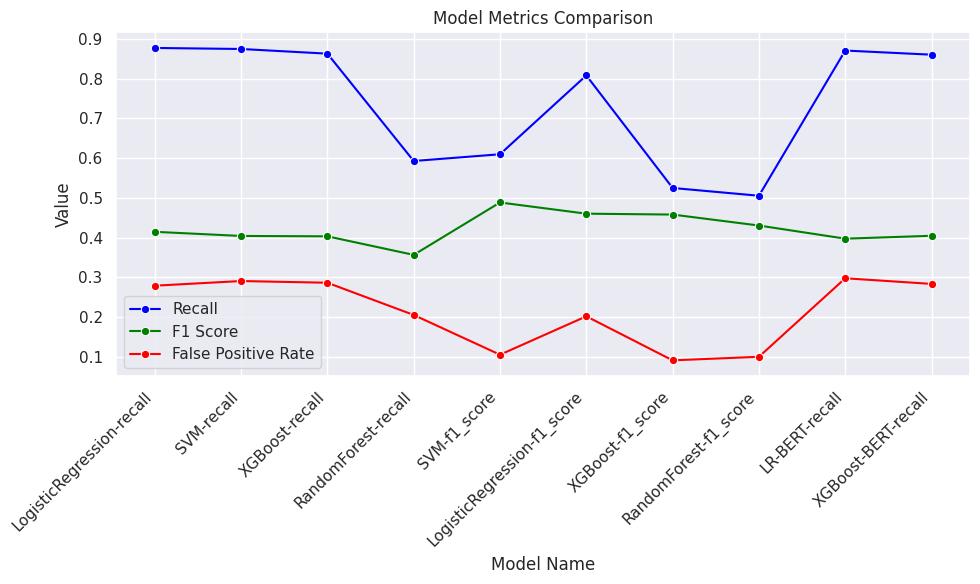

In [25]:
df = candidates.copy()

# Set seaborn style
sns.set(style="darkgrid")

# Plotting
plt.figure(figsize=(10, 6))

# Recall
sns.lineplot(x='best', y='recall', data=df, marker='o', label='Recall', color='blue')

# F1 Score
sns.lineplot(x='best', y='f1_score', data=df, marker='o', label='F1 Score', color='green')

# False Positive Rate
sns.lineplot(x='best', y='false_positive_rate', data=df, marker='o', label='False Positive Rate', color='red')

# Labels and title
plt.xlabel('Model Name')
plt.ylabel('Value')
plt.title('Model Metrics Comparison')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig('Model Comparison.png')
plt.show()

Here, we can see that there are not too much of a difference with our word embeddings and vectorized product description input.

**Summary**

For the scope of this project, we would just stop here for now for the BERT model input as we were only interesting in if the training with word embedding of product description would make a difference compared to vectorization. Here, the results shows not much of a difference. However, there are definitely much more things to try in terms of the input. Here, we listed some future steps:

- Try reducing dimension in a way other than PCA (which we've already tried). For example, for product types, only include dummies for a few that has high sales and asign others to "others".

- Consider deep learning model with word embeddings to see the difference in results.

- Consider a different way of identifying trending. Look into representation learning and see if we can figure out a way to identify trending.

# Interpretable ML

In this part we try to interpret our ML models. We would like to know how each features contributes the most to our prediction. We would first get top N feature importance since we have 1128 features. Then we would look at some shapely values. We will look at the interpretable ML with the best param XGBoost model.

**Getting the best XGBoost Model**

In [ ]:
get_params('XGBoost', 'recall')

model_name                                       model_params  precision  \
2    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.262928   

     recall  f1_score  accuracy  false_positive_rate    best  
2  0.862924  0.403049  0.729595             0.286178  recall

{'clf__learning_rate': 0.01, 'clf__n_estimators': 100}

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 100,
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.71      0.83      6475
        True       0.26      0.86      0.40       766

    accuracy                           0.73      7241
   macro avg       0.62      0.79      0.61      7241
weighted avg       0.90      0.73      0.78      7241



## Feature Importance

In [ ]:
# Get feature importance scores
feature_importance = pipe.named_steps['clf'].feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
selected = feature_importance_df.head(30)

In [ ]:
selected

Feature  Importance
1047                 cat__index_group_name_Divided    0.112406
1048              cat__index_group_name_Ladieswear    0.092888
1075            cat__section_name_Ladies H&M Sport    0.051111
1077                        cat__section_name_Mama    0.037144
1063            cat__section_name_Divided Projects    0.029805
1067                        cat__section_name_H&M+    0.029345
1097                cat__section_name_Womens Trend    0.022806
461                                    desc__vneck    0.019668
191                                     desc__high    0.017884
1095  cat__section_name_Womens Swimwear, beachwear    0.017542
273                                    desc__notch    0.016533
1094              cat__section_name_Womens Premium    0.016403
494                           desc__zip fly button    0.015966
1086         cat__section_name_Special Collections    0.015439
651                                       name__eq    0.013388
983                                        name__w    0.013228
1000                         normalise__unit_price    0.011542
1056          cat__section_name_Contemporary Smart    0.010268
1049                cat__index_group_name_Menswear    0.010216
1064            cat__section_name_Divided Selected    0.010089
199                desc__hookandeye fastening back    0.009983
60                                 desc__concealed    0.009296
1059           cat__section_name_Divided Asia keys    0.008438
686                                       name__hw    0.008333
1090  cat__section_name_Womens Everyday Collection    0.007364
1061          cat__section_name_Divided Collection    0.007269
63                              desc__contain wool    0.007202
69                             desc__cotton jersey    0.007097
1060              cat__section_name_Divided Basics    0.007053
1084               cat__section_name_Men Underwear    0.006784

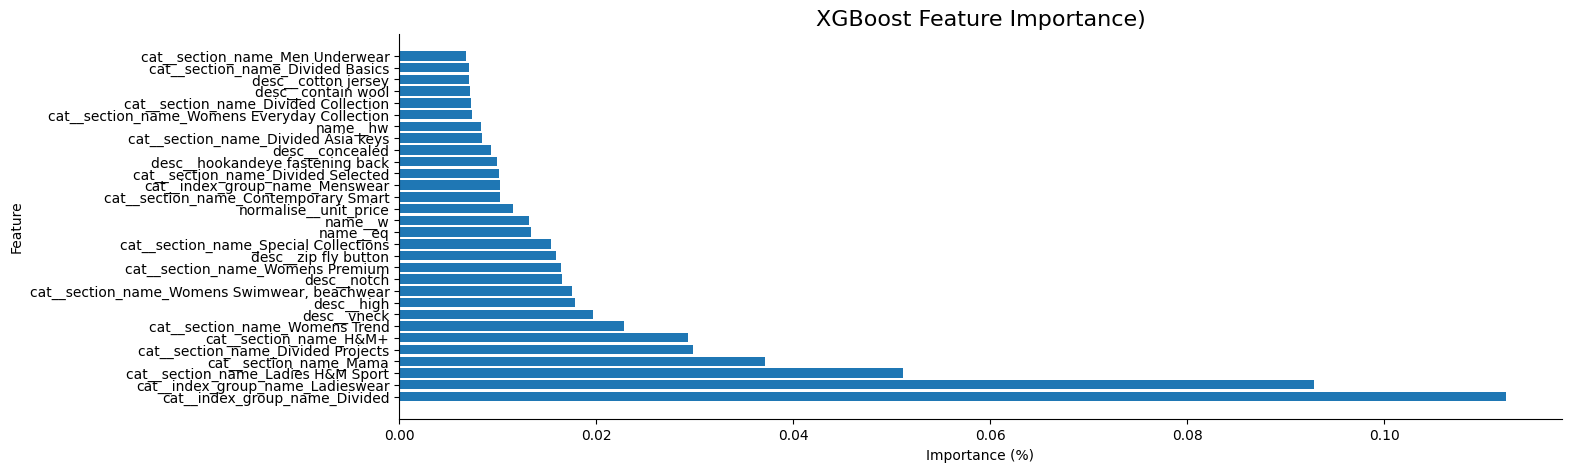

In [ ]:
plt.figure(figsize=(15,5))
plt.barh(selected['Feature'], selected['Importance'])
plt.title('XGBoost Feature Importance)', fontsize=16)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
sns.despine()
plt.show()

Here we can see that a lot of section name and index name are of high importance in predicting trending. However, we can also see that words like vneck, high, and notch also plays an important part according to our feature importance.

## Shapely Values

Next, let's look at the shapely values.

In [26]:
# !pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
# Fit tree-specific kernel for SHAP
explainer = shap.TreeExplainer(pipe.named_steps['clf'])

# Obtain SHAP values
shap_values = explainer.shap_values(X_train_df)


In [ ]:
shap_values.shape

(28962, 1128)

Shapely version of feature importance:

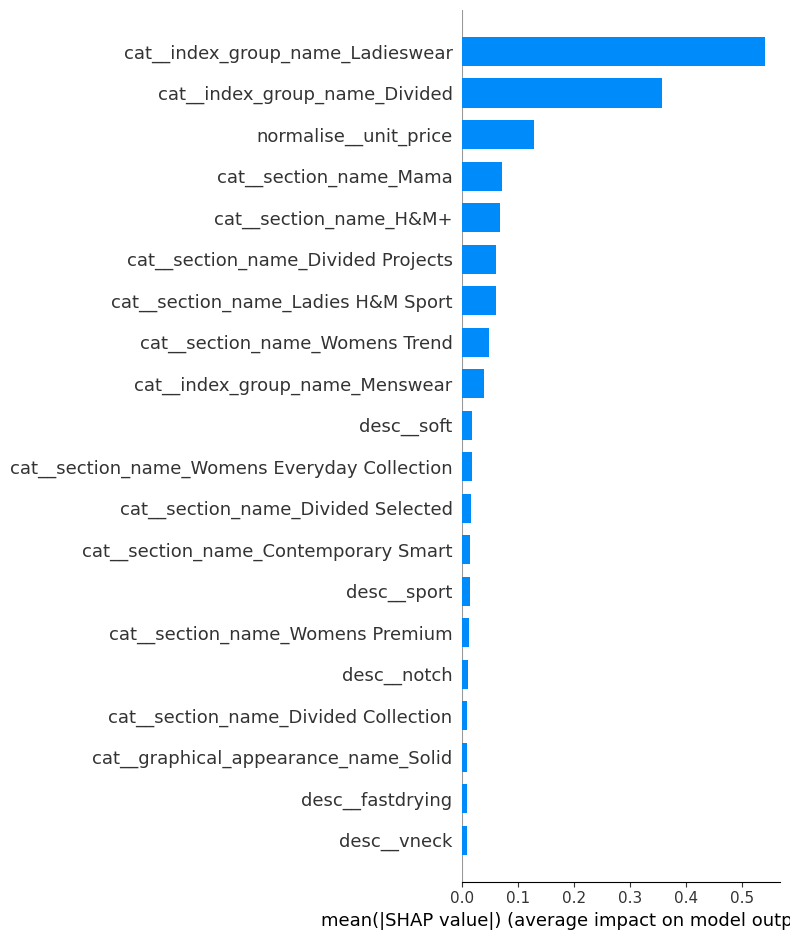

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train_df.columns, plot_type='bar')

Except for section name and index name here, we can also see words like soft, vneck appearing. This might indicated fabrics being a trending factor as well. We can look into that and provide the information to stakeholder to ask for more data that corresponds to fabrics (As there are no such data in the dataset provided)

**BeeSwarm Plot**

We can creata a beeswarm plot to highlight important relationships between features and impact on the model (predicting the trending target)

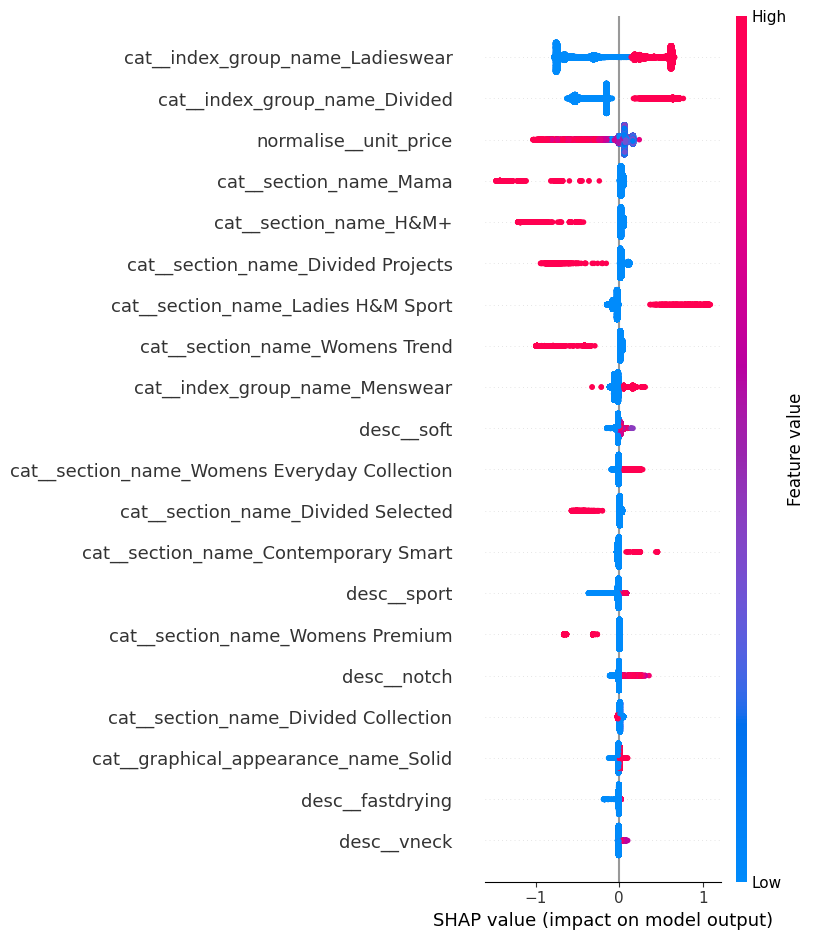

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train_df.columns)

We are looking at certain section actaully has a negative impact on predicting trending, while they are on the top selling sections. On the contrary, section like Ladies H&M Sport have a positive impact on trending. Let's get a function to get a glimpse of the product image within those sections.

In [6]:
articles = pd.read_csv(path + 'data/articles.csv')

In [3]:
import os

def find_jpg_files(root_folder):
    jpg_files = []
    for foldername, subfolders, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                jpg_files.append(os.path.splitext(filename)[0])
    return jpg_files

# Replace 'root_folder' with the actual root folder containing your JPG files
root_folder = '/Users/wellswang/Documents/BrainStation/DS/Capstone/CapstoneProject-BS/notebooks/data/images/'

images_names = find_jpg_files(root_folder)

In [4]:
image_name_df = pd.DataFrame(images_names, columns = ["image_name"])
image_name_df["article_id"] = image_name_df["image_name"].apply(lambda x: int(x[1:]))

In [7]:
image_article_df = articles[["article_id", "product_code", "product_group_name", "product_type_name", "section_name"]].merge(image_name_df, on=["article_id"], how="left")
print(image_article_df.shape)
image_article_df.head()

(105542, 6)


article_id  product_code  product_group_name product_type_name  \
0   108775015        108775  Garment Upper body          Vest top   
1   108775044        108775  Garment Upper body          Vest top   
2   108775051        108775  Garment Upper body          Vest top   
3   110065001        110065           Underwear               Bra   
4   110065002        110065           Underwear               Bra   

             section_name  image_name  
0  Womens Everyday Basics  0108775015  
1  Womens Everyday Basics  0108775044  
2  Womens Everyday Basics  0108775051  
3         Womens Lingerie  0110065001  
4         Womens Lingerie  0110065002

In [12]:
col = 'section_name'
def plot_image_samples(image_article_df, col_value, cols=1, rows=-1):
    image_path = "/Users/wellswang/Documents/BrainStation/DS/Capstone/CapstoneProject-BS/notebooks/data/images/"
    _df = image_article_df.loc[image_article_df[col]==col_value]
    article_ids = _df.article_id.values[0:cols*rows]
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    for i in range(cols * rows):
        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(f"{col} {article_id[:3]}\n{article_id}.jpg")
        image = Image.open(f"{image_path}{article_id[:3]}/{article_id}.jpg")
        plt.imshow(image)

In [11]:
print(image_article_df.section_name.unique())

['Womens Everyday Basics' 'Womens Lingerie'
 'Womens Nightwear, Socks & Tigh' 'Baby Essentials & Complements'
 'Men Underwear' 'Mama' 'Womens Small accessories' 'Men H&M Sport'
 'Kids Boy' 'Divided Basics' 'Girls Underwear & Basics' 'Mens Outerwear'
 'Womens Big accessories' 'Divided Accessories'
 'Womens Swimwear, beachwear' 'Divided Selected' 'Boys Underwear & Basics'
 'Contemporary Street' 'Contemporary Casual' 'Men Accessories'
 'Men Suits & Tailoring' 'Womens Everyday Collection' 'Men Shoes'
 'Young Boy' 'H&M+' 'Divided Collection' 'Ladies Denim'
 'Contemporary Smart' 'Womens Trend' 'Kids Outerwear' 'Young Girl'
 'Womens Shoes' 'Womens Tailoring' 'Divided Projects' 'Denim Men'
 'Men Other' 'Womens Jackets' 'Men Other 2' 'Baby Boy' 'Womens Casual'
 'Kids Accessories, Swimwear & D' 'Ladies H&M Sport' 'Kids & Baby Shoes'
 'Baby Girl' 'Kids Girl' 'Divided Complements Other' 'Womens Premium'
 'Special Collections' 'Kids Sports' 'Men Project' 'Men Edition'
 'Collaborations' 'Divided Asi

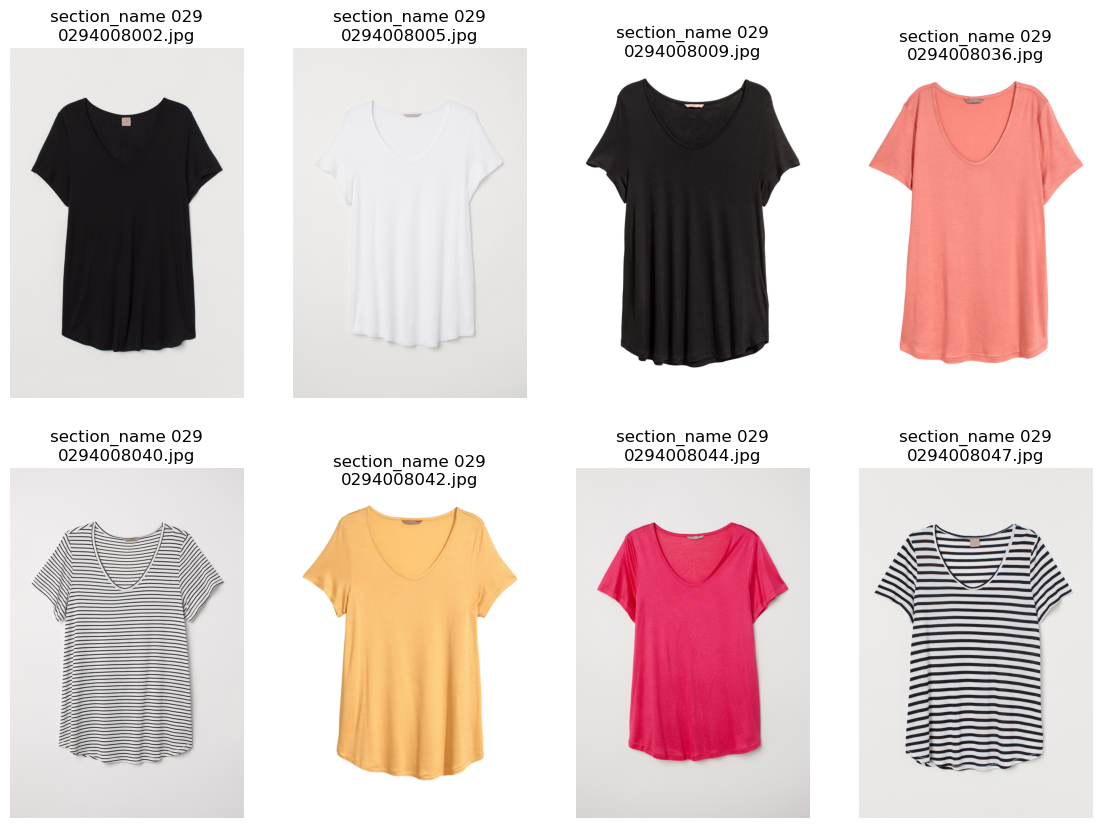

In [13]:
from PIL import Image
plot_image_samples(image_article_df, 'H&M+', 4,2)

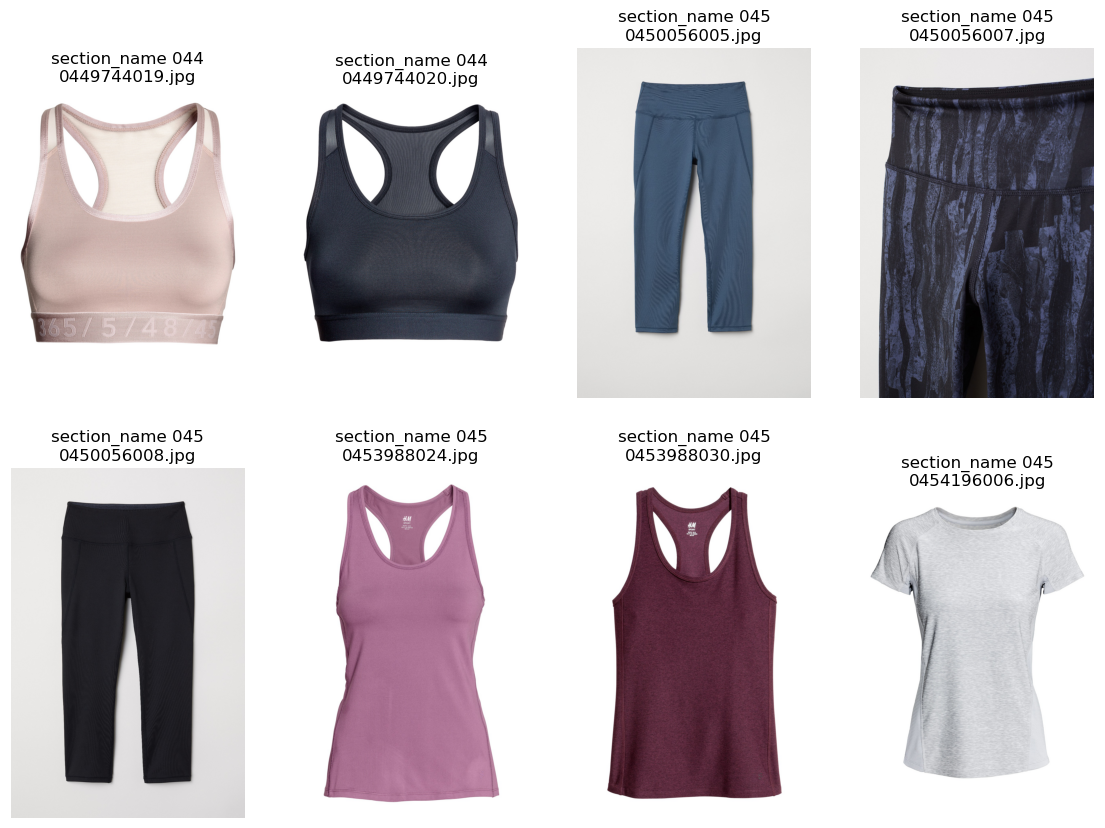

In [14]:
from PIL import Image
plot_image_samples(image_article_df, 'Ladies H&M Sport', 4,2)

# Case Studies

With the pipeline, we can easily replicate the work on our desired case study. Here, we want to explore different product types. We hand picked two product types, vest top and trousers (best selling).

## Vest top (product_type_name)

**Prepare Input with Case Data**

In [ ]:
vt_df = prod_df[prod_df['product_type_name']=='Vest top']

In [ ]:
# Spliting features X and target y
X = vt_df.drop(['trending', 'product_id'], axis=1)
y = vt_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train_transformed = col_trans.fit_transform(X_train)
X_test_transformed = col_trans.transform(X_test)

X_train = X_train_transformed.toarray()
X_test = X_test_transformed.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(881, 8) (221, 8)


((881, 61), (221, 61))

In [ ]:
X_train_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_train)
X_test_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_test)


# Display the shapes of DataFrames
print("X_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)

X_train_df shape: (881, 61)
X_test_df shape: (221, 61)


**Grid Search - XGBoost**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 1 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.75      0.83       182
        True       0.38      0.72      0.50        39

    accuracy                           0.75       221
   macro avg       0.65      0.74      0.67       221
weighted avg       0.83      0.75      0.77       221



model_name                                       model_params  precision  \
0    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.383562   

     recall  f1_score  accuracy  false_positive_rate  
0  0.717949       0.5  0.746606             0.247253

**Best Model Results**

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 100,
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.75      0.83       182
        True       0.38      0.72      0.50        39

    accuracy                           0.75       221
   macro avg       0.65      0.74      0.67       221
weighted avg       0.83      0.75      0.77       221



Here we can see that the model is performing not as well in terms of recall (0.72) but it out performs all of our previous model training on the whole data in terms of f1-score (0.5). We wouls also like to see the interpretability of this case.

**Shapely Values**

In [ ]:
# Fit tree-specific kernel for SHAP
explainer = shap.TreeExplainer(pipe.named_steps['clf'])

# Obtain SHAP values
shap_values = explainer.shap_values(X_train_df)

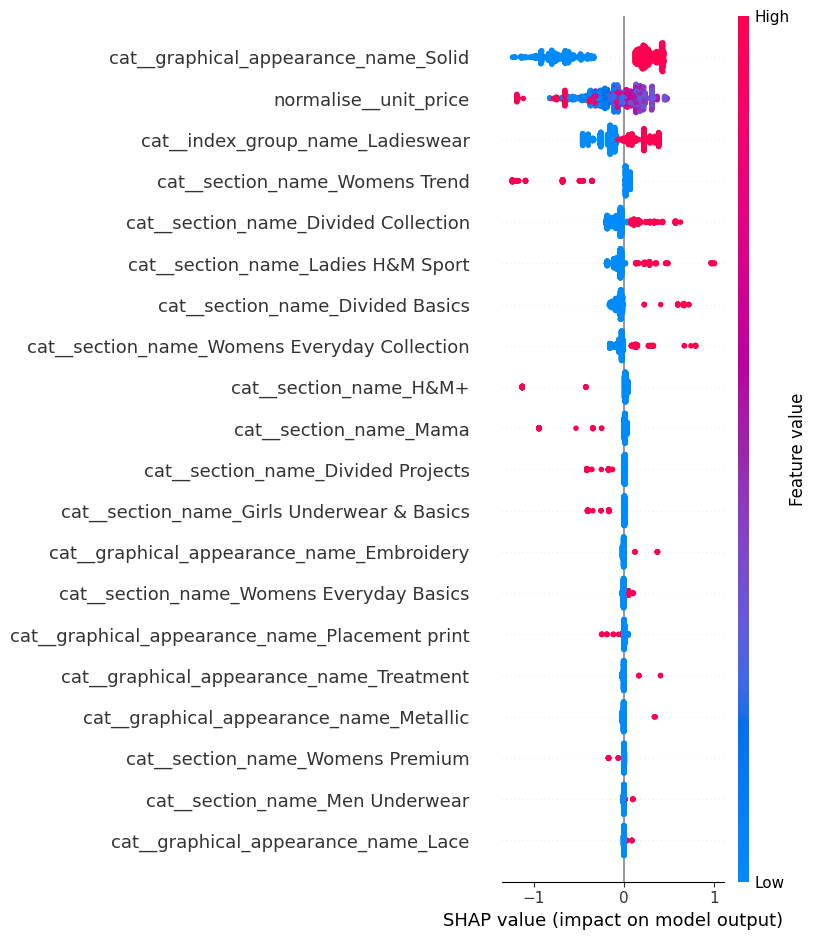

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train_df.columns)

We can see that for vest top, the attribute "graphical appearance solid or not" is of high impact for predicting trending. This could be an insight to further look into and discuss with our stakeholders.

**Training with SVM**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'SVM'
    model_params = {'C':c, 'kernel':'rbf'}
    model = SVC(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


model_name                   model_params  precision    recall  f1_score  \
0        SVM  {'C': 0.001, 'kernel': 'rbf'}   0.440000  0.564103  0.494382   
1        SVM   {'C': 0.01, 'kernel': 'rbf'}   0.440000  0.564103  0.494382   
2        SVM    {'C': 0.1, 'kernel': 'rbf'}   0.482143  0.692308  0.568421   
3        SVM      {'C': 1, 'kernel': 'rbf'}   0.393939  0.666667  0.495238   
4        SVM     {'C': 10, 'kernel': 'rbf'}   0.390625  0.641026  0.485437   
5        SVM    {'C': 100, 'kernel': 'rbf'}   0.393939  0.666667  0.495238   

   accuracy  false_positive_rate  
0  0.796380             0.153846  
1  0.796380             0.153846  
2  0.814480             0.159341  
3  0.760181             0.219780  
4  0.760181             0.214286  
5  0.760181             0.219780

Here, we can see that SVM works with higher f1_score (0.57), while having a trade-off for recall (0.69), which is similar as we saw with the previous models.

## Trousers (product_type_name)

**Prepare Input with Case Data**

In [ ]:
vt_df = prod_df[prod_df['product_type_name']=='Trousers']

In [ ]:
# Spliting features X and target y
X = vt_df.drop(['trending', 'product_id'], axis=1)
y = vt_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train_transformed = col_trans.fit_transform(X_train)
X_test_transformed = col_trans.transform(X_test)

X_train = X_train_transformed.toarray()
X_test = X_test_transformed.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(3729, 8) (933, 8)


((3729, 72), (933, 72))

In [ ]:
X_train_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_train)
X_test_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_test)


# Display the shapes of DataFrames
print("X_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)

X_train_df shape: (3729, 72)
X_test_df shape: (933, 72)


**Grid Search - XGBoost**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 1 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.80      0.89       855
        True       0.30      0.92      0.45        78

    accuracy                           0.81       933
   macro avg       0.64      0.86      0.67       933
weighted avg       0.93      0.81      0.85       933



model_name                                       model_params  precision  \
0    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.297521   

     recall  f1_score  accuracy  false_positive_rate  
0  0.923077      0.45  0.811361              0.19883

**Best Model Results**

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 100,
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.80      0.89       855
        True       0.30      0.92      0.45        78

    accuracy                           0.81       933
   macro avg       0.64      0.86      0.67       933
weighted avg       0.93      0.81      0.85       933



Here we can see entirely different result from the vest top case. We can see a high recall (0.92), with f1-score still better than our previous models.

**Shapely Values**

In [ ]:
# Fit tree-specific kernel for SHAP
explainer = shap.TreeExplainer(pipe.named_steps['clf'])

# Obtain SHAP values
shap_values = explainer.shap_values(X_train_df)

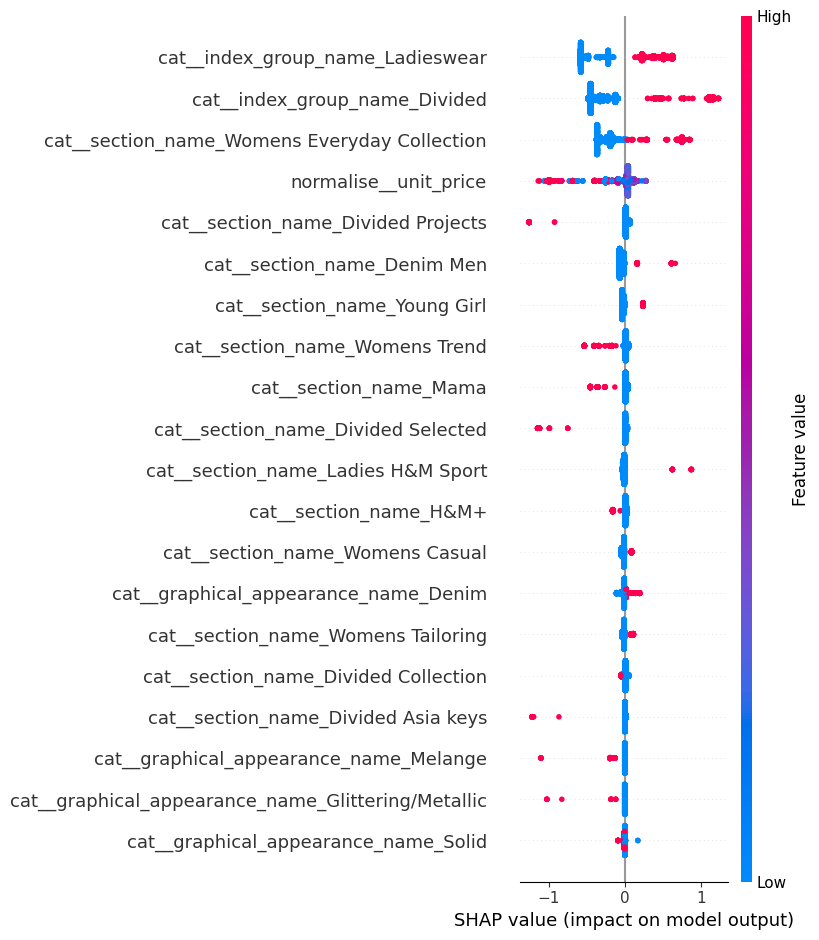

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train_df.columns)

The shapely value for this case looks similar to the main model. However, we are looking at some data points with high positive impact on trending for "Denim Men" and "Young Girl" section.

**Training with SVM**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Empty dataframe to store results
all_metrics_df = pd.DataFrame()

# For loop through different C's for logistic regression
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
for c in tqdm(Cs, desc="Looping through Cs", position=0, leave=True):
    # Specify the model for the pipeline
    model_name = 'SVM'
    model_params = {'C':c, 'kernel':'rbf'}
    model = SVC(**model_params)

    # Instantiate pipeline with our custom function
    pipe = hm_pipeline(model)

    # Fitting the pipeline with training data
    pipe.fit(X_train, y_train)

    # Predicting with test data
    y_pred = pipe.predict(X_test)

    # Calculate metrics and include model specifications
    metrics_df = calculate_metrics(model_name, model_params, y_test, y_pred)

    # Append the metrics_df to the all_metrics_df
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

# Display the resulting DataFrame
all_metrics_df

Looping through Cs: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


model_name                   model_params  precision    recall  f1_score  \
0        SVM  {'C': 0.001, 'kernel': 'rbf'}   0.234201  0.807692  0.363112   
1        SVM   {'C': 0.01, 'kernel': 'rbf'}   0.279528  0.910256  0.427711   
2        SVM    {'C': 0.1, 'kernel': 'rbf'}   0.293388  0.910256  0.443750   
3        SVM      {'C': 1, 'kernel': 'rbf'}   0.290456  0.897436  0.438871   
4        SVM     {'C': 10, 'kernel': 'rbf'}   0.296460  0.858974  0.440789   
5        SVM    {'C': 100, 'kernel': 'rbf'}   0.298165  0.833333  0.439189   

   accuracy  false_positive_rate  
0  0.763130             0.240936  
1  0.796356             0.214035  
2  0.809218             0.200000  
3  0.808146             0.200000  
4  0.817792             0.185965  
5  0.822079             0.178947

SVM results looks quite similar to XGBoost for this case. In combination, XGBoost is a better model for the Trouser case.

## Manually tuning dummy variables

As mentioned in the previous notebook, we would also like to lower the dimensionality by asigning categories to others, leaving only dummies with top sales. We would like to see if this change the results. Here we create a new df and test this out.

In [ ]:
for col in prod_df.columns[3:8]:
    print(f'-------- {col} ----------')
    print(prod_df[prod_df['product_group_name']=='Garment Upper body'][col].unique())

-------- product_type_name ----------
['Sweater' 'Blouse' 'Cardigan' 'Vest top' 'T-shirt' 'Top' 'Shirt' 'Jacket'
 'Hoodie' 'Bodysuit' 'Polo shirt' 'Coat' 'Blazer' 'Tailored Waistcoat'
 'Outdoor Waistcoat']
-------- product_group_name ----------
['Garment Upper body']
-------- index_group_name ----------
['Divided' 'Ladieswear' 'Baby/Children' 'Sport' 'Menswear']
-------- section_name ----------
['Divided Selected' 'Womens Everyday Collection' 'Womens Tailoring'
 'Divided Collection' 'Divided Basics' 'Divided Projects' 'Womens Trend'
 'Kids Boy' 'H&M+' 'Ladies H&M Sport' 'Contemporary Smart' 'Kids Girl'
 'Young Girl' 'Womens Jackets' 'Womens Everyday Basics' 'Baby Girl'
 'Girls Underwear & Basics' 'Womens Casual' 'Contemporary Casual'
 'Kids Outerwear' 'Womens Nightwear, Socks & Tigh' 'Womens Premium'
 'Baby Essentials & Complements' 'Men Underwear' 'Baby Boy'
 'Mens Outerwear' 'Contemporary Street' 'Kids Local Relevance'
 'Men Suits & Tailoring' 'Men H&M Sport' 'Mama' 'Special Collecti

In [ ]:
top_section = ['Womens Everyday Collection', 'Divided Collection', 'Womens Swimwear, beachwear']
top_appearance = ['Solid', 'Melange', 'All over pattern']
top_index = ['Ladieswear', 'Devided']
new_prod_df = prod_df.copy()
new_prod_df['section_name'] = np.where(new_prod_df['section_name'].isin(top_section), new_prod_df['section_name'], 'Other')
new_prod_df['graphical_appearance_name'] = np.where(new_prod_df['graphical_appearance_name'].isin(top_appearance), new_prod_df['graphical_appearance_name'], 'Other')
new_prod_df['index_group_name'] = np.where(new_prod_df['index_group_name'].isin(top_index), new_prod_df['index_group_name'], 'Other')


new_prod_df.head()
for col in new_prod_df.columns[3:8]:
    print(f'-------- {col} ----------')
    print(new_prod_df[new_prod_df['product_group_name']=='Garment Upper body'][col].unique())

-------- product_type_name ----------
['Sweater' 'Blouse' 'Cardigan' 'Vest top' 'T-shirt' 'Top' 'Shirt' 'Jacket'
 'Hoodie' 'Bodysuit' 'Polo shirt' 'Coat' 'Blazer' 'Tailored Waistcoat'
 'Outdoor Waistcoat']
-------- product_group_name ----------
['Garment Upper body']
-------- index_group_name ----------
['Other' 'Ladieswear']
-------- section_name ----------
['Other' 'Womens Everyday Collection' 'Divided Collection'
 'Womens Swimwear, beachwear']
-------- graphical_appearance_name ----------
['Melange' 'Solid' 'Other' 'All over pattern']


### New df results

In [ ]:
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']

# Create the column transformations list + columns to which to apply
col_transforms = [
    # ('desc', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'detail_desc'),
    # ('name', TfidfVectorizer(max_features=500, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 3)), 'prod_name'),
    ('normalise', StandardScaler(), ['unit_price']),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
]

# Create the column transformer
# col_trans = ColumnTransformer(col_transforms, remainder='passthrough')
col_trans = ColumnTransformer(col_transforms)

In [ ]:
# Spliting features X and target y
X = new_prod_df.drop(['trending', 'product_id'], axis=1)
y = new_prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train_transformed = col_trans.fit_transform(X_train)
X_test_transformed = col_trans.transform(X_test)

X_train = X_train_transformed.toarray()
X_test = X_test_transformed.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 8) (7241, 8)


((28962, 54), (7241, 54))

In [ ]:
X_train_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_train)
X_test_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_test)


# Display the shapes of DataFrames
print("X_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)

X_train_df shape: (28962, 54)
X_test_df shape: (7241, 54)


In [ ]:
# Set the random seed for reproducibility
np.random.seed(123)

# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)

# Define the hyperparameter grid to search
param_grid = {
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'clf__n_estimators': [50, 100, 200, 300, 500]
}

# Use GridSearchCV to find the best combination of hyperparameters
scorings = ['precision', 'recall', 'f1', 'accuracy']
grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring=scorings, verbose=2, n_jobs=4, pre_dispatch=8, refit='recall')

# Record the start time
start_time = time.time()

# Fit the model
grid_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
tt = round(elapsed_time/60)
print(f"Elapsed Time: {tt} minutes")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate metrics and include model specifications
metrics_df = calculate_metrics(model_name, best_params, y_test, y_pred)
metrics_df

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Elapsed Time: 1 minutes
Best hyperparameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.71      0.82      6475
        True       0.23      0.75      0.36       766

    accuracy                           0.71      7241
   macro avg       0.60      0.73      0.59      7241
weighted avg       0.88      0.71      0.77      7241



model_name                                       model_params  precision  \
0    XGBoost  {'clf__learning_rate': 0.01, 'clf__n_estimator...   0.234598   

     recall  f1_score  accuracy  false_positive_rate  
0  0.750653  0.357476  0.714542              0.28973

In [ ]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 100,
                'tree_method':'gpu_hist',
                'gpu_id':0,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.71      0.82      6475
        True       0.23      0.75      0.36       766

    accuracy                           0.71      7241
   macro avg       0.60      0.73      0.59      7241
weighted avg       0.88      0.71      0.77      7241



Here, we are not look at any better performances. However, we can check if there are any other insights with the shapely values.

In [ ]:
# Fit tree-specific kernel for SHAP
explainer = shap.TreeExplainer(pipe.named_steps['clf'])

# Obtain SHAP values
shap_values = explainer.shap_values(X_train_df)

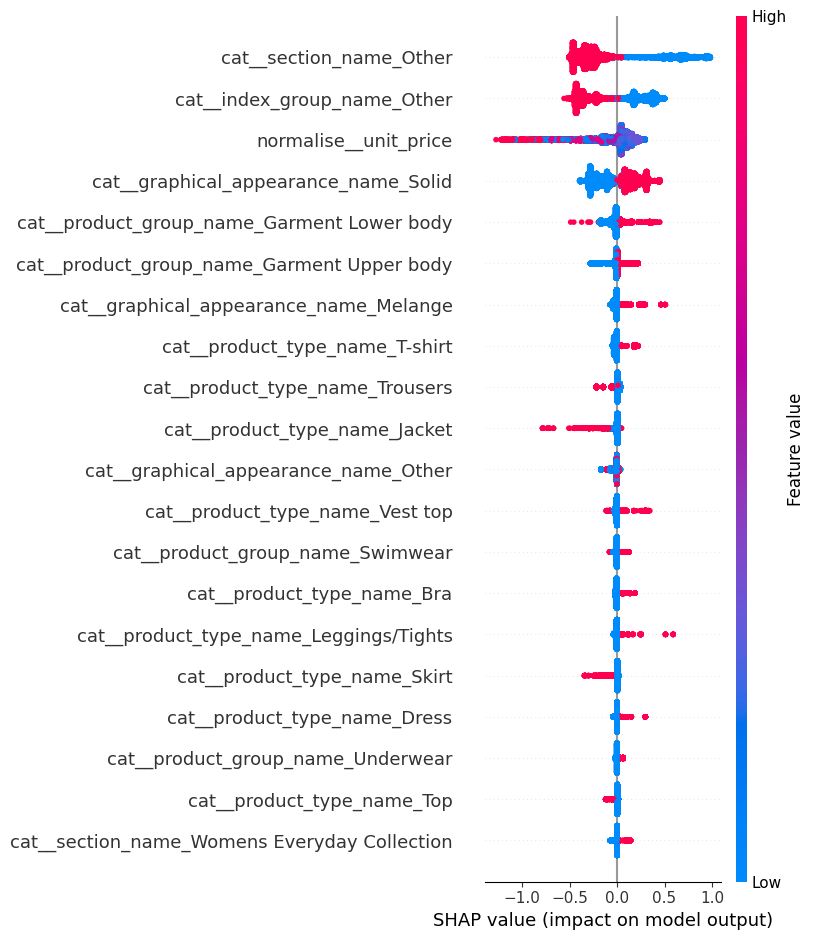

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train_df.columns)

More diverse patterns for feature's impact on trending can be seen here. Melange appearance, T-shirt, Bra, Leggings are having positive impact, while Jackets and those that are select as others are having negative impacts.

# Post Model EDA

## Product section_name

In the modelling phase, we discovered that section is of high feature importance when predicting trending. Here we did a analysis by creating a function to conduct EDA with different sections.

In [15]:
hm_sales = pd.read_csv(path + 'data/hm_sales.csv')
hm_sales.shape

(28813419, 26)

In [38]:
hm_sales.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

   unit_price  units sales_channel                 prod_name  \
0    0.030492      1        Online   Rae Push (Melbourne) 2p   
1    0.050831      1        Online  Atlanta Push Body Harlow   
2    0.020322      1        Online               Inca Jumper   
3    0.015237      1        Online               Inca Jumper   
4    0.016932      1        Online      W YODA KNIT OL OFFER   

  product_type_name  product_group_name graphical_appearance_name  ...  \
0               Bra           Underwear                     Solid  ...   
1    Underwear body           Underwear                     Solid  ...   
2           Sweater  Garment Upper body                   Melange  ...   
3           Sweater  Garment Upper body                   Melange  ...   
4           Sweater  Garment Upper body                   Melange  ...   

  index_group_name                section_name garment_group_name  \
0       Ladieswear             Womens Lingerie  Under-, Nightwear   
1       Ladieswear             Womens Lingerie  Under-, Nightwear   
2          Divided            Divided Selected           Knitwear   
3          Divided            Divided Selected           Knitwear   
4       Ladieswear  Womens Everyday Collection     Special Offers   

                                         detail_desc     FN Active  \
0  Lace push-up bras with underwired, moulded, pa...  False  False   
1  Lace push-up body with underwired, moulded, pa...  False  False   
2  Jumper in rib-knit cotton with hard-worn detai...   True   True   
3  Jumper in rib-knit cotton with hard-worn detai...   True   True   
4  V-neck knitted jumper with long sleeves and ri...   True   True   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  24.0   
1             ACTIVE                   NONE  24.0   
2             ACTIVE              Regularly  32.0   
3             ACTIVE              Regularly  32.0   
4             ACTIVE              Regularly  32.0   

                                         postal_code  
0  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
1  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
2  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
3  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  
4  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  

[5 rows x 25 columns]

**Looking at sections sales over time**

In [39]:
hm_sales.section_name.unique()

array(['Womens Lingerie', 'Divided Selected',
       'Womens Everyday Collection', 'Womens Tailoring',
       'Divided Collection', 'Divided Basics', 'Womens Big accessories',
       'Divided Projects', 'Womens Trend', 'Denim Men',
       'Womens Nightwear, Socks & Tigh', 'Baby Boy', 'Kids Boy',
       'Special Collections', 'Kids Accessories, Swimwear & D', 'H&M+',
       'Baby Essentials & Complements', 'Ladies H&M Sport',
       'Womens Everyday Basics', 'Divided Accessories', 'Men Accessories',
       'Contemporary Smart', 'Girls Underwear & Basics', 'Kids Girl',
       'Young Girl', 'Ladies Denim', 'Womens Jackets',
       'Womens Small accessories', 'Baby Girl', 'Womens Shoes',
       'Womens Casual', 'Womens Premium', 'Womens Swimwear, beachwear',
       'Contemporary Casual', 'Kids Outerwear', 'Boys Underwear & Basics',
       'Kids & Baby Shoes', 'Men Underwear', 'Mens Outerwear',
       'Contemporary Street', 'Kids Local Relevance', 'Men Shoes',
       'Men Suits & Tailoring'

In [16]:
# Creating a function for retrieving weekly sales with input section
def weekly_sales_section(section_name):
    # filter df
    df = hm_sales[hm_sales['section_name']==section_name]
    name = df['section_name'].unique()[0]
    print(f'section: {section_name}')

    # Calculate the percentage of sales for this product compared to tatal
    sales_pct = round(df.shape[0]*100/ hm_sales.shape[0],2)
    print(f'Percentage of Sales: {sales_pct}%')

    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')

    # Keeping only units column
    df = df.loc[:,['units']]

    # Aggregate by week
    df = df.resample('W').sum()
    return df

In [17]:
# selecting top selling product as sample_product
section_name = 'Womens Everyday Collection'
WEC_weekly = weekly_sales_section(section_name)
WEC_weekly.T.head()

section: Womens Everyday Collection
Percentage of Sales: 18.61%


t_dat  2018-09-23  2018-09-30  2018-10-07  2018-10-14  2018-10-21  2018-10-28  \
units       33243       74105       41946       55918       53191       66074   

t_dat  2018-11-04  2018-11-11  2018-11-18  2018-11-25  ...  2020-07-26  \
units       49276       45730       46905       81009  ...       48738   

t_dat  2020-08-02  2020-08-09  2020-08-16  2020-08-23  2020-08-30  2020-09-06  \
units       51836       54583       49347       45949       52773       48871   

t_dat  2020-09-13  2020-09-20  2020-09-27  
units       55313       48859       13716  

[1 rows x 106 columns]

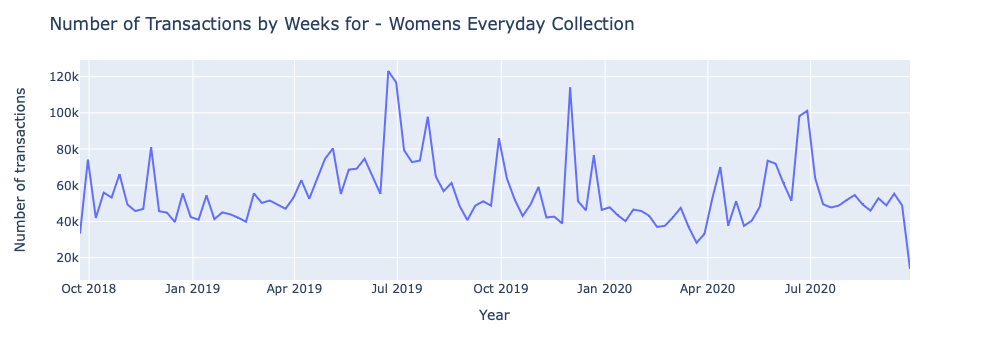

In [18]:
df = WEC_weekly
# looking at the sales for this product over time
fig = px.line(df, x=df.index, y="units",)
fig.update_layout(
    yaxis_title="Number of transactions",
    xaxis_title="Year",
    legend_title="",
    title=f"Number of Transactions by Weeks for - {section_name}"
)
fig.show();

section: H&M+
Percentage of Sales: 1.73%
section: Womens Everyday Collection
Percentage of Sales: 18.61%


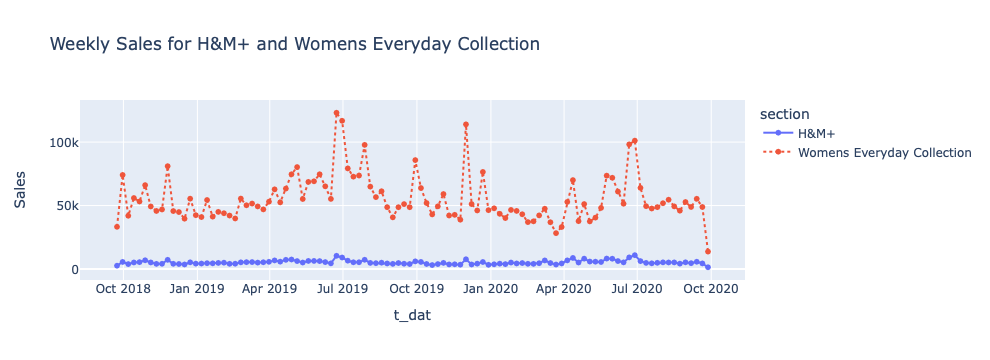

In [19]:
# Comparing sales of different sections
def compare_section_weekly_sales(sec_A, sec_B):
    df_A = weekly_sales_section(sec_A)
    df_B = weekly_sales_section(sec_B)
    df_A['section'] = sec_A
    df_B['section'] = sec_B
    df = pd.concat([df_A, df_B])

    # Create line plot with two categories
    fig = px.line(df, x=df.index, y='units', color='section', markers=True, line_dash='section',
              labels={'df.index': 'Time', 'units': 'Sales'},
              title=f'Weekly Sales for {sec_A} and {sec_B}')
    fig.show()

compare_section_weekly_sales('H&M+', 'Womens Everyday Collection')


section: H&M+
Percentage of Sales: 1.73%
section: Ladies H&M Sport
Percentage of Sales: 3.77%


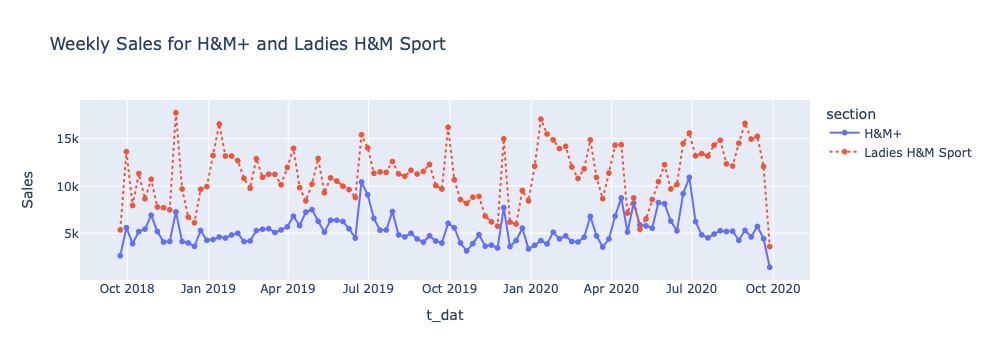

In [20]:
compare_section_weekly_sales('H&M+', 'Ladies H&M Sport')

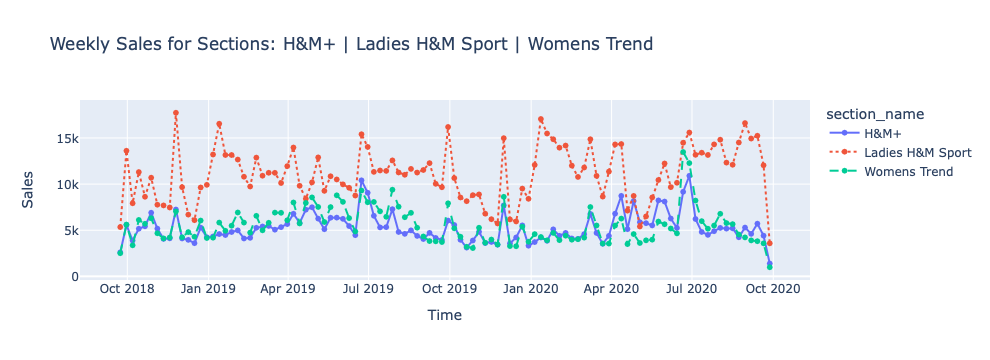

In [21]:
# Comparing sales of different sections
def compare_section_weekly_sales(sections):
    # filter df
    df = hm_sales[hm_sales['section_name'].isin(sections)]
    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')
    df = df.groupby('section_name')['units'].resample('W').sum().reset_index()

    # Create line plot with two categories
    fig = px.line(df, x='t_dat', y='units', color='section_name', markers=True, line_dash='section_name',
              labels={'t_dat': 'Time', 'units': 'Sales'},
              title='Weekly Sales for Sections: ' +' | '.join([f"{i}" for i in sections]))
    fig.show()

sections = ['H&M+', 'Ladies H&M Sport', 'Womens Trend']
compare_section_weekly_sales(sections)


Here, we can observe that "Ladies H&M Sport", which is the section we found of high positive impact for trending in our model, is having different sales patterns with the other two sections. We can see that during early months of the year it would have peaked in sales. This might have to do with product launch, campaigns, or winter sport events. We might need to ask for more context and discuss with the stakeholders to see if it is an actionable insight.

## Trending Analysis

Here we want to analyze how trending correponds to each category columns.

In [47]:
prod_df = pd.read_csv(path + 'data/prod_df.csv')

In [48]:
prod_df

product_id                 prod_name  \
0          541518   Rae Push (Melbourne) 2p   
1          663713  Atlanta Push Body Harlow   
2          505221               Inca Jumper   
3          685687      W YODA KNIT OL OFFER   
4          501323      Thomas paperbag wide   
...           ...                       ...   
36198      875646               Emanuel set   
36199      900550      COLLAB W.CHEN JOGGER   
36200      930405                 Ghost L/S   
36201      930283         Chip Hood 19.99:-   
36202      913290  NASA Bryson Pile 39.99:-   

                                             detail_desc product_type_name  \
0      Lace push-up bras with underwired, moulded, pa...               Bra   
1      Lace push-up body with underwired, moulded, pa...    Underwear body   
2      Jumper in rib-knit cotton with hard-worn detai...           Sweater   
3      V-neck knitted jumper with long sleeves and ri...           Sweater   
4      Trousers in woven fabric with a high, paper ba...          Trousers   
...                                                  ...               ...   
36198  Set with a long-sleeved top in sweatshirt fabr...          Trousers   
36199  Whooli Chen x H&M. Joggers in sweatshirt fabri...          Trousers   
36200  Calf-length dress in a jacquard weave with a r...             Dress   
36201  Hoodie in soft sweatshirt fabric with a text p...            Hoodie   
36202  Long-sleeved jacket in soft faux shearling wit...           Sweater   

       product_group_name index_group_name                section_name  \
0               Underwear       Ladieswear             Womens Lingerie   
1               Underwear       Ladieswear             Womens Lingerie   
2      Garment Upper body          Divided            Divided Selected   
3      Garment Upper body       Ladieswear  Womens Everyday Collection   
4      Garment Lower body       Ladieswear            Womens Tailoring   
...                   ...              ...                         ...   
36198  Garment Lower body    Baby/Children                    Kids Boy   
36199  Garment Lower body    Baby/Children                    Kids Boy   
36200   Garment Full body       Ladieswear  Womens Everyday Collection   
36201  Garment Upper body         Menswear         Contemporary Street   
36202  Garment Upper body         Menswear         Contemporary Street   

      graphical_appearance_name  unit_price  trending  
0                         Solid    0.030492      True  
1                         Solid    0.050831     False  
2                       Melange    0.020322     False  
3                       Melange    0.016932      True  
4                         Check    0.059305      True  
...                         ...         ...       ...  
36198          All over pattern    0.033881     False  
36199          All over pattern    0.030492     False  
36200           Other structure    0.067780     False  
36201           Placement print    0.033881     False  
36202           Placement print    0.067780     False  

[36203 rows x 10 columns]

In [49]:
prod_df['product_group_name'].value_counts()

Garment Upper body    17165
Garment Lower body     8491
Garment Full body      7192
Underwear              1965
Swimwear               1390
Name: product_group_name, dtype: int64

In [51]:
df = prod_df.copy()
df['trending'] = np.where(df['trending'], 'yes', 'no')

def trending_by_columns(df, column):
    rate_data = df.groupby([column, "trending"])["trending"].count() / df.groupby(column)["trending"].count()
    rate_data.unstack()[["yes", "no"]].sort_values("no").head(10).plot(kind="barh", stacked=True, color=["cornflowerblue", "lightcoral"])
    plt.title(f"Registration rate per {column} category")
    sns.despine()
    plt.show()


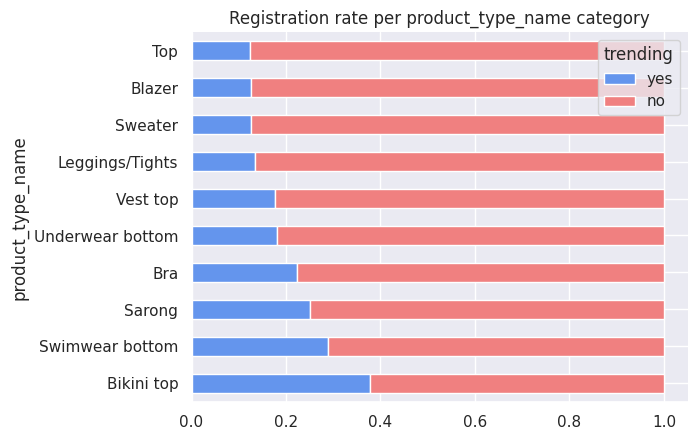

In [52]:
col = 'product_type_name'
trending_by_columns(df, col)

For product type, we can see that Bikini top have the highest proportion of trending items. In general, swimwear and summer wear seems to have higher trending proportions. On the other hand, for winter wear, sweater and blazer are the two product types with highest trending rate.

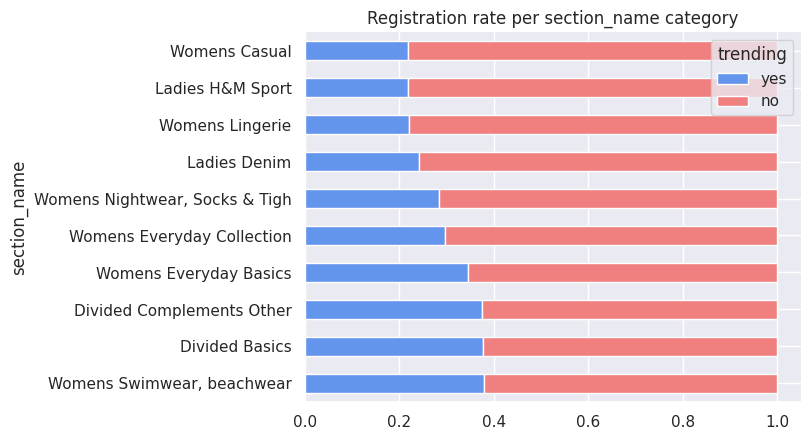

In [53]:
col = "section_name"
trending_by_columns(df, col)

Sections tells the same story as the top trending section being the "Womens Swimwear, beachwear.

# Conclusion

In this notebook, we have continued our work with advanced modelling. Here are some details:

- **Target Variable (Trending)**: Trending is defined as observing a high volume of sales combined with high week-over-week growth. We use specific thresholds to set precisely what 'high' means.

- **Pipeline**: For efficiency purposes and reusability, we created a pipeline that wraps up all our feature engineering steps and modelling with column transformer and pipelines. We've also enabled GPU training with grid search and our pipelines.

- **Modelling**: Train our models with the custom pipeline, do hyperparameter optimization with grid search. (Logistic Regression, SVM, XGBoost, and Random Forest)
    - We've optimized the model with both recall and f1 score,
    - For recall, we discovered that Logistic Regression, XGBoost, and SVM are having similar results (Logreg the best)
    - For f1 score, we discovered that SVM has the highest score.  
 
- **Word Embeddings**: We would like to see if word embeddings would out perform vectorization for our product description input. Here, we've used BERT pretrained model for embedding that. In our modelling, BERT is having similar results with the previous vevtorized input. However, we need to dive in more to validate that. We would delegate that to future works.

- **Interpretable ML**: We've used shapely values to understand which features have high impact on predicting trending. We discovered that certain sections have higher positive/negative impact in predicting trending. We've used a function to take a glimpse into the product image of those sections.

- **Case Studies**: We've implement the pipeline on training only for indivudual product type. We've seen the results change if we train only with certain product types. We've also viewed the shapely values for our case study, and discovered insights corresponding to each case.